# Interactive train and test audio samples limited in length audio normalized

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

In [2]:
!rm -rf runs

In [3]:
import sys
sys.path.append('/home/catskills/Desktop/openasr20/end2end_asr_pytorch')

import os
os.environ['IN_JUPYTER']='True'

%matplotlib inline
import matplotlib.pylab as plt

from audio_chunk_size import audio_chunk_size
from glob import glob
from models.asr.transformer import Transformer, Encoder, Decoder
from torch.autograd import Variable
from torch.cuda.amp import GradScaler, autocast
from utils import constant
from utils.data_loader import SpectrogramDataset, AudioDataLoader, BucketingSampler
from utils.functions import save_model, load_model, init_transformer_model, init_optimizer
from utils.lstm_utils import LM
from utils.metrics import calculate_metrics, calculate_cer, calculate_wer, calculate_cer_en_zh
from utils.optimizer import NoamOpt
import json, logging, math, os, random, time, torch, sys, random
import numpy as np
import torch.nn as nn
from TrainerVanilla import TrainerVanilla

language='amharic'
stage='NIST'
chunks = list(sorted(glob(f'{stage}/openasr20_{language}/build/transcription_split/*.txt')))

n_samples=len(chunks)
print(n_samples, 'chunks')
size_chunks=list(sorted([audio_chunk_size(fn) for fn in chunks]))

9842 chunks


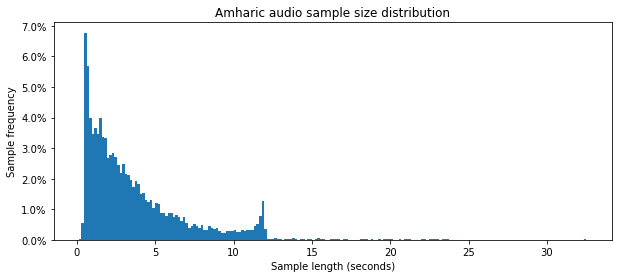

In [4]:
from matplotlib.ticker import PercentFormatter
data = [x for x,y in size_chunks]
plt.figure(figsize=(10,4))
plt.hist(data, weights=np.ones(len(data)) / len(data), bins=200)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Sample length (seconds)')
plt.ylabel('Sample frequency')
plt.title('Amharic audio sample size distribution')
plt.savefig(f'analysis/{language}/{language}_audio_sample_size.png')
plt.show()

In [5]:
cap=5
F=[x for x in size_chunks if x[0] <= cap]
L=[]
for length, text in F:
    audio=text.replace('transcription_split','audio_split_normalized_to_18db').replace('txt', 'wav')
    L.append(f'{audio},{text}')
n_samples=len(L)
print(f'{len(L)} samples up to {length}s or {100*n_samples/len(size_chunks)}%')

7492 samples up to 5.0s or 76.12273928063402%


In [1]:
!pwd

/home/catskills/Desktop/openasr20


In [6]:
manifest_file_path=f'analysis/{language}/size_1.csv'
with open(manifest_file_path,'w') as f:
    f.write('\n'.join(L))

model_dir=f'save/{language}_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4'

args=constant.args
args.continue_from=None
args.cuda = True
args.labels_path = f'analysis/{language}/{language}_characters.json'
args.lr = 1e-4
args.name = f'{language}_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4'
args.save_folder = f'save'
args.epochs = 1000
args.save_every = 1
args.feat_extractor = f'vgg_cnn'
args.dropout = 0.1
args.num_layers = 4
args.num_heads = 8
args.dim_model = 512
args.dim_key = 64
args.dim_value = 64
args.dim_input = 161
args.dim_inner = 2048
args.dim_emb = 512
args.shuffle=True
args.min_lr = 1e-6
args.k_lr = 1
args.sample_rate=8000
args.train_manifest_list = [manifest_file_path]
args.continue_from=f'{model_dir}/best_model.th'

args.augment=True

audio_conf = dict(sample_rate=args.sample_rate,
                  window_size=args.window_size,
                  window_stride=args.window_stride,
                  window=args.window,
                  noise_dir=args.noise_dir,
                  noise_prob=args.noise_prob,
                  noise_levels=(args.noise_min, args.noise_max))

with open(args.labels_path, 'r') as label_file:
    labels = str(''.join(json.load(label_file)))

# add PAD_CHAR, SOS_CHAR, EOS_CHAR
labels = constant.PAD_CHAR + constant.SOS_CHAR + constant.EOS_CHAR + labels
label2id, id2label = {}, {}
count = 0
for i in range(len(labels)):
    if labels[i] not in label2id:
        label2id[labels[i]] = count
        id2label[count] = labels[i]
        count += 1
    else:
        print("multiple label: ", labels[i])

if constant.args.continue_from:
        model, opt, epoch, metrics, loaded_args, label2id, id2label = load_model(
            constant.args.continue_from)
        start_epoch = epoch  # index starts from zero
        verbose = constant.args.verbose
else:
    model = init_transformer_model(constant.args, label2id, id2label)
    opt = init_optimizer(constant.args, model, "noam")

start_epoch = epoch
metrics = None
loaded_args = None
verbose = True

constant.USE_CUDA=True

train_data = SpectrogramDataset(audio_conf, manifest_filepath_list=args.train_manifest_list, 
                                label2id=label2id, normalize=True, augment=args.augment)

loss_type = args.loss
model = model.cuda(0)
num_epochs = start_epoch + 2000

In [7]:
args.batch_size=10
train_sampler = BucketingSampler(train_data, batch_size=args.batch_size)
train_loader = AudioDataLoader(train_data, num_workers=args.num_workers, batch_sampler=train_sampler)
trainer = TrainerVanilla()
trainer.train(model, train_loader, train_sampler, opt, loss_type, start_epoch, num_epochs, label2id, id2label, metrics)

(Epoch 15268) TRAIN LOSS:1.0613 CER:35.31% LR:0.0000188: 100%|██████████| 750/750 [03:19<00:00,  3.77it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15268.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15269) TRAIN LOSS:1.0554 CER:35.25% LR:0.0000188: 100%|██████████| 750/750 [03:15<00:00,  3.84it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15269.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15270) TRAIN LOSS:1.0580 CER:35.33% LR:0.0000188: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15270.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15271) TRAIN LOSS:1.0548 CER:35.14% LR:0.0000188: 100%|██████████| 750/750 [03:15<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15271.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15272) TRAIN LOSS:1.0499 CER:34.98% LR:0.0000188: 100%|██████████| 750/750 [03:16<00:00,  3.82it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15272.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15273) TRAIN LOSS:1.0490 CER:34.84% LR:0.0000188: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15273.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15274) TRAIN LOSS:1.0507 CER:34.92% LR:0.0000188: 100%|██████████| 750/750 [03:16<00:00,  3.82it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15274.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15275) TRAIN LOSS:1.0478 CER:34.87% LR:0.0000188: 100%|██████████| 750/750 [03:16<00:00,  3.82it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15275.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15276) TRAIN LOSS:1.0445 CER:34.62% LR:0.0000188: 100%|██████████| 750/750 [03:16<00:00,  3.81it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15276.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15277) TRAIN LOSS:1.0470 CER:34.81% LR:0.0000188: 100%|██████████| 750/750 [03:16<00:00,  3.81it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15277.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15278) TRAIN LOSS:1.0461 CER:34.74% LR:0.0000188: 100%|██████████| 750/750 [03:15<00:00,  3.84it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15278.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15279) TRAIN LOSS:1.0384 CER:34.60% LR:0.0000187: 100%|██████████| 750/750 [03:20<00:00,  3.75it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15279.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15280) TRAIN LOSS:1.0394 CER:34.46% LR:0.0000187: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15280.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15281) TRAIN LOSS:1.0341 CER:34.31% LR:0.0000187: 100%|██████████| 750/750 [03:15<00:00,  3.83it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15281.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15282) TRAIN LOSS:1.0351 CER:34.23% LR:0.0000187: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15282.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15283) TRAIN LOSS:1.0310 CER:34.07% LR:0.0000187: 100%|██████████| 750/750 [03:13<00:00,  3.88it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15283.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15284) TRAIN LOSS:1.0290 CER:34.13% LR:0.0000187: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15284.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15285) TRAIN LOSS:1.0267 CER:34.05% LR:0.0000187: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15285.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15286) TRAIN LOSS:1.0261 CER:33.87% LR:0.0000187: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15286.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15287) TRAIN LOSS:1.0283 CER:34.08% LR:0.0000187: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15287.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15288) TRAIN LOSS:1.0248 CER:33.93% LR:0.0000187: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15288.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15289) TRAIN LOSS:1.0235 CER:33.76% LR:0.0000187: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15289.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15290) TRAIN LOSS:1.0216 CER:33.88% LR:0.0000187: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15290.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15291) TRAIN LOSS:1.0208 CER:33.73% LR:0.0000187: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15291.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15292) TRAIN LOSS:1.0181 CER:33.67% LR:0.0000187: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15292.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15293) TRAIN LOSS:1.0169 CER:33.67% LR:0.0000187: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15293.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15294) TRAIN LOSS:1.0139 CER:33.38% LR:0.0000187: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15294.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15295) TRAIN LOSS:1.0129 CER:33.42% LR:0.0000186: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15295.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15296) TRAIN LOSS:1.0150 CER:33.51% LR:0.0000186: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15296.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15297) TRAIN LOSS:1.0101 CER:33.20% LR:0.0000186: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15297.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15298) TRAIN LOSS:1.0092 CER:33.39% LR:0.0000186: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15298.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15299) TRAIN LOSS:1.0097 CER:33.32% LR:0.0000186: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15299.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15300) TRAIN LOSS:1.0056 CER:32.97% LR:0.0000186: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15300.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15301) TRAIN LOSS:1.0056 CER:33.21% LR:0.0000186: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15301.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15302) TRAIN LOSS:1.0039 CER:33.06% LR:0.0000186: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15302.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15303) TRAIN LOSS:1.0030 CER:33.03% LR:0.0000186: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15303.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15304) TRAIN LOSS:1.0004 CER:32.89% LR:0.0000186: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15304.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15305) TRAIN LOSS:1.0011 CER:32.96% LR:0.0000186: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15305.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15306) TRAIN LOSS:1.0000 CER:32.75% LR:0.0000186: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15306.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15307) TRAIN LOSS:0.9968 CER:32.63% LR:0.0000186: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15307.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15308) TRAIN LOSS:0.9966 CER:32.68% LR:0.0000186: 100%|██████████| 750/750 [03:14<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15308.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15309) TRAIN LOSS:0.9933 CER:32.49% LR:0.0000186: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15309.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15310) TRAIN LOSS:0.9911 CER:32.41% LR:0.0000186: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15310.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15311) TRAIN LOSS:0.9890 CER:32.16% LR:0.0000185: 100%|██████████| 750/750 [03:19<00:00,  3.76it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15311.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15312) TRAIN LOSS:0.9885 CER:32.21% LR:0.0000185: 100%|██████████| 750/750 [03:18<00:00,  3.78it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15312.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15313) TRAIN LOSS:0.9888 CER:32.26% LR:0.0000185: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15313.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15314) TRAIN LOSS:0.9870 CER:32.25% LR:0.0000185: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15314.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15315) TRAIN LOSS:0.9854 CER:32.16% LR:0.0000185: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15315.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15316) TRAIN LOSS:0.9818 CER:31.92% LR:0.0000185: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15316.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15317) TRAIN LOSS:0.9853 CER:32.28% LR:0.0000185: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15317.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15318) TRAIN LOSS:0.9808 CER:31.89% LR:0.0000185: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15318.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15319) TRAIN LOSS:0.9816 CER:32.12% LR:0.0000185: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15319.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15320) TRAIN LOSS:0.9770 CER:31.83% LR:0.0000185: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15320.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15321) TRAIN LOSS:0.9769 CER:31.82% LR:0.0000185: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15321.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15322) TRAIN LOSS:0.9762 CER:31.72% LR:0.0000185: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15322.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15323) TRAIN LOSS:0.9759 CER:31.78% LR:0.0000185: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15323.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15324) TRAIN LOSS:0.9730 CER:31.64% LR:0.0000185: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15324.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15325) TRAIN LOSS:0.9716 CER:31.34% LR:0.0000185: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15325.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15326) TRAIN LOSS:0.9706 CER:31.39% LR:0.0000185: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15326.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15327) TRAIN LOSS:0.9721 CER:31.42% LR:0.0000184: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15327.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15328) TRAIN LOSS:0.9690 CER:31.49% LR:0.0000184: 100%|██████████| 750/750 [03:13<00:00,  3.88it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15328.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15329) TRAIN LOSS:0.9653 CER:31.25% LR:0.0000184: 100%|██████████| 750/750 [03:15<00:00,  3.84it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15329.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15330) TRAIN LOSS:0.9650 CER:31.38% LR:0.0000184: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15330.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15331) TRAIN LOSS:0.9645 CER:31.18% LR:0.0000184: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15331.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15332) TRAIN LOSS:0.9640 CER:31.15% LR:0.0000184: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15332.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15333) TRAIN LOSS:0.9606 CER:31.09% LR:0.0000184: 100%|██████████| 750/750 [03:14<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15333.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15334) TRAIN LOSS:0.9599 CER:30.98% LR:0.0000184: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15334.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15335) TRAIN LOSS:0.9592 CER:31.15% LR:0.0000184: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15335.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15336) TRAIN LOSS:0.9568 CER:30.91% LR:0.0000184: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15336.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15337) TRAIN LOSS:0.9560 CER:30.85% LR:0.0000184: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15337.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15338) TRAIN LOSS:0.9579 CER:30.92% LR:0.0000184: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15338.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15339) TRAIN LOSS:0.9539 CER:30.72% LR:0.0000184: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15339.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15340) TRAIN LOSS:0.9528 CER:30.70% LR:0.0000184: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15340.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15341) TRAIN LOSS:0.9509 CER:30.66% LR:0.0000184: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15341.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15342) TRAIN LOSS:0.9501 CER:30.56% LR:0.0000184: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15342.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15343) TRAIN LOSS:0.9487 CER:30.50% LR:0.0000184: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15343.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15344) TRAIN LOSS:0.9473 CER:30.34% LR:0.0000183: 100%|██████████| 750/750 [03:14<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15344.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15345) TRAIN LOSS:0.9461 CER:30.36% LR:0.0000183: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15345.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15346) TRAIN LOSS:0.9447 CER:30.31% LR:0.0000183: 100%|██████████| 750/750 [03:14<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15346.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15347) TRAIN LOSS:0.9469 CER:30.55% LR:0.0000183: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15347.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15348) TRAIN LOSS:0.9429 CER:30.17% LR:0.0000183: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15348.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15349) TRAIN LOSS:0.9411 CER:30.18% LR:0.0000183: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15349.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15350) TRAIN LOSS:0.9422 CER:30.31% LR:0.0000183: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15350.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15351) TRAIN LOSS:0.9403 CER:30.14% LR:0.0000183: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15351.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15352) TRAIN LOSS:0.9404 CER:30.00% LR:0.0000183: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15352.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15353) TRAIN LOSS:0.9365 CER:29.86% LR:0.0000183: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15353.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15354) TRAIN LOSS:0.9357 CER:29.90% LR:0.0000183: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15354.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15355) TRAIN LOSS:0.9358 CER:29.87% LR:0.0000183: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15355.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15356) TRAIN LOSS:0.9330 CER:29.62% LR:0.0000183: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15356.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15357) TRAIN LOSS:0.9346 CER:29.86% LR:0.0000183: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15357.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15358) TRAIN LOSS:0.9315 CER:29.73% LR:0.0000183: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15358.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15359) TRAIN LOSS:0.9287 CER:29.58% LR:0.0000183: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15359.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15360) TRAIN LOSS:0.9306 CER:29.66% LR:0.0000183: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15360.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15361) TRAIN LOSS:0.9273 CER:29.57% LR:0.0000182: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15361.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15362) TRAIN LOSS:0.9271 CER:29.37% LR:0.0000182: 100%|██████████| 750/750 [03:16<00:00,  3.82it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15362.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15363) TRAIN LOSS:0.9236 CER:29.22% LR:0.0000182: 100%|██████████| 750/750 [03:17<00:00,  3.79it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15363.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15364) TRAIN LOSS:0.9264 CER:29.43% LR:0.0000182: 100%|██████████| 750/750 [03:15<00:00,  3.84it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15364.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15365) TRAIN LOSS:0.9213 CER:29.25% LR:0.0000182: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15365.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15366) TRAIN LOSS:0.9194 CER:29.08% LR:0.0000182: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15366.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15367) TRAIN LOSS:0.9202 CER:29.13% LR:0.0000182: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15367.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15368) TRAIN LOSS:0.9188 CER:28.92% LR:0.0000182: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15368.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15369) TRAIN LOSS:0.9191 CER:29.12% LR:0.0000182: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15369.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15370) TRAIN LOSS:0.9160 CER:28.97% LR:0.0000182: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15370.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15371) TRAIN LOSS:0.9147 CER:28.90% LR:0.0000182: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15371.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15372) TRAIN LOSS:0.9177 CER:29.00% LR:0.0000182: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15372.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15373) TRAIN LOSS:0.9141 CER:28.84% LR:0.0000182: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15373.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15374) TRAIN LOSS:0.9128 CER:28.80% LR:0.0000182: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15374.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15375) TRAIN LOSS:0.9116 CER:28.73% LR:0.0000182: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15375.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15376) TRAIN LOSS:0.9100 CER:28.58% LR:0.0000182: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15376.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15377) TRAIN LOSS:0.9067 CER:28.54% LR:0.0000182: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15377.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15378) TRAIN LOSS:0.9073 CER:28.53% LR:0.0000181: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15378.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15379) TRAIN LOSS:0.9065 CER:28.57% LR:0.0000181: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15379.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15380) TRAIN LOSS:0.9071 CER:28.43% LR:0.0000181: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15380.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15381) TRAIN LOSS:0.9041 CER:28.30% LR:0.0000181: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15381.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15382) TRAIN LOSS:0.9060 CER:28.37% LR:0.0000181: 100%|██████████| 750/750 [03:14<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15382.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15383) TRAIN LOSS:0.9036 CER:28.27% LR:0.0000181: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15383.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15384) TRAIN LOSS:0.9014 CER:28.11% LR:0.0000181: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15384.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15385) TRAIN LOSS:0.9002 CER:28.13% LR:0.0000181: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15385.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15386) TRAIN LOSS:0.8986 CER:28.08% LR:0.0000181: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15386.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15387) TRAIN LOSS:0.8980 CER:28.11% LR:0.0000181: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15387.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15388) TRAIN LOSS:0.8941 CER:27.75% LR:0.0000181: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15388.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15389) TRAIN LOSS:0.8970 CER:27.95% LR:0.0000181: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15389.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15390) TRAIN LOSS:0.8926 CER:27.77% LR:0.0000181: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15390.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15391) TRAIN LOSS:0.8950 CER:27.88% LR:0.0000181: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15391.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15392) TRAIN LOSS:0.8923 CER:27.64% LR:0.0000181: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15392.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15393) TRAIN LOSS:0.8926 CER:27.73% LR:0.0000181: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15393.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15394) TRAIN LOSS:0.8880 CER:27.55% LR:0.0000181: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15394.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15395) TRAIN LOSS:0.8890 CER:27.63% LR:0.0000181: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15395.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15396) TRAIN LOSS:0.8903 CER:27.73% LR:0.0000180: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15396.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15397) TRAIN LOSS:0.8870 CER:27.49% LR:0.0000180: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15397.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15398) TRAIN LOSS:0.8855 CER:27.26% LR:0.0000180: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15398.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15399) TRAIN LOSS:0.8866 CER:27.58% LR:0.0000180: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15399.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15400) TRAIN LOSS:0.8860 CER:27.45% LR:0.0000180: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15400.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15401) TRAIN LOSS:0.8837 CER:27.24% LR:0.0000180: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15401.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15402) TRAIN LOSS:0.8835 CER:27.15% LR:0.0000180: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15402.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15403) TRAIN LOSS:0.8802 CER:27.07% LR:0.0000180: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15403.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15404) TRAIN LOSS:0.8789 CER:27.05% LR:0.0000180: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15404.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15405) TRAIN LOSS:0.8787 CER:26.98% LR:0.0000180: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15405.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15406) TRAIN LOSS:0.8794 CER:27.22% LR:0.0000180: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15406.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15407) TRAIN LOSS:0.8792 CER:27.07% LR:0.0000180: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15407.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15408) TRAIN LOSS:0.8786 CER:26.91% LR:0.0000180: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15408.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15409) TRAIN LOSS:0.8775 CER:26.99% LR:0.0000180: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15409.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15410) TRAIN LOSS:0.8761 CER:26.89% LR:0.0000180: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15410.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15411) TRAIN LOSS:0.8699 CER:26.73% LR:0.0000180: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15411.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15412) TRAIN LOSS:0.8728 CER:26.62% LR:0.0000180: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15412.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15413) TRAIN LOSS:0.8733 CER:26.85% LR:0.0000180: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15413.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15414) TRAIN LOSS:0.8690 CER:26.61% LR:0.0000179: 100%|██████████| 750/750 [03:14<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15414.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15415) TRAIN LOSS:0.8697 CER:26.61% LR:0.0000179: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15415.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15416) TRAIN LOSS:0.8698 CER:26.48% LR:0.0000179: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15416.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15417) TRAIN LOSS:0.8679 CER:26.47% LR:0.0000179: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15417.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15418) TRAIN LOSS:0.8651 CER:26.39% LR:0.0000179: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15418.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15419) TRAIN LOSS:0.8623 CER:26.16% LR:0.0000179: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15419.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15420) TRAIN LOSS:0.8684 CER:26.48% LR:0.0000179: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15420.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15421) TRAIN LOSS:0.8640 CER:26.34% LR:0.0000179: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15421.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15422) TRAIN LOSS:0.8614 CER:26.16% LR:0.0000179: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15422.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15423) TRAIN LOSS:0.8619 CER:26.04% LR:0.0000179: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15423.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15424) TRAIN LOSS:0.8593 CER:25.94% LR:0.0000179: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15424.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15425) TRAIN LOSS:0.8597 CER:26.07% LR:0.0000179: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15425.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15426) TRAIN LOSS:0.8592 CER:25.99% LR:0.0000179: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15426.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15427) TRAIN LOSS:0.8580 CER:26.03% LR:0.0000179: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15427.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15428) TRAIN LOSS:0.8541 CER:25.74% LR:0.0000179: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15428.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15429) TRAIN LOSS:0.8537 CER:25.70% LR:0.0000179: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15429.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15430) TRAIN LOSS:0.8562 CER:25.97% LR:0.0000179: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15430.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15431) TRAIN LOSS:0.8537 CER:25.77% LR:0.0000179: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15431.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15432) TRAIN LOSS:0.8538 CER:25.80% LR:0.0000178: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15432.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15433) TRAIN LOSS:0.8506 CER:25.54% LR:0.0000178: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15433.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15434) TRAIN LOSS:0.8493 CER:25.60% LR:0.0000178: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15434.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15435) TRAIN LOSS:0.8477 CER:25.56% LR:0.0000178: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15435.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15436) TRAIN LOSS:0.8457 CER:25.33% LR:0.0000178: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15436.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15437) TRAIN LOSS:0.8469 CER:25.43% LR:0.0000178: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15437.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15438) TRAIN LOSS:0.8474 CER:25.45% LR:0.0000178: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15438.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15439) TRAIN LOSS:0.8457 CER:25.37% LR:0.0000178: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15439.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15440) TRAIN LOSS:0.8450 CER:25.33% LR:0.0000178: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15440.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15441) TRAIN LOSS:0.8413 CER:25.01% LR:0.0000178: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15441.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15442) TRAIN LOSS:0.8428 CER:25.20% LR:0.0000178: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15442.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15443) TRAIN LOSS:0.8423 CER:25.00% LR:0.0000178: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15443.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15444) TRAIN LOSS:0.8433 CER:25.23% LR:0.0000178: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15444.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15445) TRAIN LOSS:0.8411 CER:25.01% LR:0.0000178: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15445.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15446) TRAIN LOSS:0.8371 CER:24.87% LR:0.0000178: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15446.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15447) TRAIN LOSS:0.8377 CER:24.82% LR:0.0000178: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15447.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15448) TRAIN LOSS:0.8389 CER:25.08% LR:0.0000178: 100%|██████████| 750/750 [03:13<00:00,  3.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15448.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15449) TRAIN LOSS:0.8363 CER:24.72% LR:0.0000178: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15449.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15450) TRAIN LOSS:0.8338 CER:24.90% LR:0.0000177: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15450.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15451) TRAIN LOSS:0.8328 CER:24.65% LR:0.0000177: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15451.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15452) TRAIN LOSS:0.8351 CER:24.84% LR:0.0000177: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15452.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15453) TRAIN LOSS:0.8355 CER:24.86% LR:0.0000177: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15453.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15454) TRAIN LOSS:0.8343 CER:24.74% LR:0.0000177: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15454.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15455) TRAIN LOSS:0.8304 CER:24.48% LR:0.0000177: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15455.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15456) TRAIN LOSS:0.8297 CER:24.34% LR:0.0000177: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15456.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15457) TRAIN LOSS:0.8298 CER:24.49% LR:0.0000177: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15457.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15458) TRAIN LOSS:0.8295 CER:24.54% LR:0.0000177: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15458.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15459) TRAIN LOSS:0.8285 CER:24.37% LR:0.0000177: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15459.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15460) TRAIN LOSS:0.8251 CER:24.22% LR:0.0000177: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15460.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15461) TRAIN LOSS:0.8248 CER:24.10% LR:0.0000177: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15461.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15462) TRAIN LOSS:0.8247 CER:24.14% LR:0.0000177: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15462.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15463) TRAIN LOSS:0.8238 CER:24.17% LR:0.0000177: 100%|██████████| 750/750 [03:15<00:00,  3.84it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15463.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15464) TRAIN LOSS:0.8254 CER:24.20% LR:0.0000177: 100%|██████████| 750/750 [03:15<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15464.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15465) TRAIN LOSS:0.8221 CER:24.01% LR:0.0000177: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15465.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15466) TRAIN LOSS:0.8211 CER:24.02% LR:0.0000177: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15466.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15467) TRAIN LOSS:0.8215 CER:24.03% LR:0.0000177: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15467.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15468) TRAIN LOSS:0.8211 CER:24.10% LR:0.0000177: 100%|██████████| 750/750 [03:15<00:00,  3.84it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15468.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15469) TRAIN LOSS:0.8193 CER:23.86% LR:0.0000176: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15469.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15470) TRAIN LOSS:0.8170 CER:23.77% LR:0.0000176: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15470.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15471) TRAIN LOSS:0.8201 CER:23.96% LR:0.0000176: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15471.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15472) TRAIN LOSS:0.8158 CER:23.61% LR:0.0000176: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15472.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15473) TRAIN LOSS:0.8170 CER:23.83% LR:0.0000176: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15473.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15474) TRAIN LOSS:0.8152 CER:23.66% LR:0.0000176: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15474.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15475) TRAIN LOSS:0.8137 CER:23.60% LR:0.0000176: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15475.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15476) TRAIN LOSS:0.8142 CER:23.63% LR:0.0000176: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15476.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15477) TRAIN LOSS:0.8117 CER:23.44% LR:0.0000176: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15477.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15478) TRAIN LOSS:0.8133 CER:23.52% LR:0.0000176: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15478.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15479) TRAIN LOSS:0.8116 CER:23.43% LR:0.0000176: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15479.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15480) TRAIN LOSS:0.8118 CER:23.46% LR:0.0000176: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15480.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15481) TRAIN LOSS:0.8079 CER:23.31% LR:0.0000176: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15481.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15482) TRAIN LOSS:0.8096 CER:23.41% LR:0.0000176: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15482.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15483) TRAIN LOSS:0.8071 CER:23.29% LR:0.0000176: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15483.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15484) TRAIN LOSS:0.8087 CER:23.27% LR:0.0000176: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15484.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15485) TRAIN LOSS:0.8049 CER:23.07% LR:0.0000176: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15485.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15486) TRAIN LOSS:0.8036 CER:23.16% LR:0.0000176: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15486.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15487) TRAIN LOSS:0.8057 CER:23.14% LR:0.0000176: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15487.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15488) TRAIN LOSS:0.8033 CER:23.04% LR:0.0000175: 100%|██████████| 750/750 [03:15<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15488.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15489) TRAIN LOSS:0.8026 CER:22.89% LR:0.0000175: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15489.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15490) TRAIN LOSS:0.8013 CER:22.86% LR:0.0000175: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15490.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15491) TRAIN LOSS:0.8048 CER:23.12% LR:0.0000175: 100%|██████████| 750/750 [03:15<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15491.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15492) TRAIN LOSS:0.8017 CER:22.97% LR:0.0000175: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15492.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15493) TRAIN LOSS:0.8000 CER:22.71% LR:0.0000175: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15493.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15494) TRAIN LOSS:0.7981 CER:22.86% LR:0.0000175: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15494.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15495) TRAIN LOSS:0.7978 CER:22.71% LR:0.0000175: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15495.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15496) TRAIN LOSS:0.7972 CER:22.55% LR:0.0000175: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15496.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15497) TRAIN LOSS:0.7939 CER:22.63% LR:0.0000175: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15497.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15498) TRAIN LOSS:0.7951 CER:22.60% LR:0.0000175: 100%|██████████| 750/750 [03:14<00:00,  3.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15498.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15499) TRAIN LOSS:0.7963 CER:22.74% LR:0.0000175: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15499.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15500) TRAIN LOSS:0.7903 CER:22.32% LR:0.0000175: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15500.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15501) TRAIN LOSS:0.7939 CER:22.45% LR:0.0000175: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15501.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15502) TRAIN LOSS:0.7928 CER:22.34% LR:0.0000175: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15502.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15503) TRAIN LOSS:0.7932 CER:22.36% LR:0.0000175: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15503.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15504) TRAIN LOSS:0.7908 CER:22.32% LR:0.0000175: 100%|██████████| 750/750 [03:15<00:00,  3.84it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15504.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15505) TRAIN LOSS:0.7881 CER:22.04% LR:0.0000175: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15505.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15506) TRAIN LOSS:0.7897 CER:22.38% LR:0.0000175: 100%|██████████| 750/750 [03:15<00:00,  3.84it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15506.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15507) TRAIN LOSS:0.7870 CER:21.94% LR:0.0000175: 100%|██████████| 750/750 [03:15<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15507.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15508) TRAIN LOSS:0.7877 CER:22.12% LR:0.0000174: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15508.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15509) TRAIN LOSS:0.7897 CER:22.17% LR:0.0000174: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15509.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15510) TRAIN LOSS:0.7854 CER:22.10% LR:0.0000174: 100%|██████████| 750/750 [03:14<00:00,  3.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15510.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15511) TRAIN LOSS:0.7845 CER:21.97% LR:0.0000174: 100%|██████████| 750/750 [03:15<00:00,  3.84it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15511.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15512) TRAIN LOSS:0.7864 CER:22.04% LR:0.0000174: 100%|██████████| 750/750 [03:20<00:00,  3.74it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15512.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15513) TRAIN LOSS:1.2721 CER:0.27% LR:0.0000174:   4%|▎         | 27/750 [00:06<03:07,  3.86it/s]


KeyboardInterrupt: 

## Eval

In [8]:
args.batch_size = 8
train_sampler = BucketingSampler(train_data, batch_size=args.batch_size)
train_loader = AudioDataLoader(train_data, num_workers=args.num_workers, batch_sampler=train_sampler)

In [9]:
args.verbose = True

In [10]:
smoothing = constant.args.label_smoothing

In [11]:
model.eval();

In [12]:
R = []

valid_loader = train_loader
total_valid_loss, total_valid_cer, total_valid_wer, total_valid_char, total_valid_word = 0, 0, 0, 0, 0
for i, (data) in enumerate(valid_loader):
    src, tgt, src_percentages, src_lengths, tgt_lengths = data
    src = src.cuda()
    tgt = tgt.cuda()
    with autocast():
        pred, gold, hyp_seq, gold_seq = model(src, src_lengths, tgt, verbose=False)

    seq_length = pred.size(1)
    sizes = Variable(src_percentages.mul_(int(seq_length)).int(), requires_grad=False)

    loss, num_correct = calculate_metrics(
        pred, gold, input_lengths=sizes, target_lengths=tgt_lengths, smoothing=smoothing, loss_type=loss_type)

    if loss.item() == float('Inf'):
        logging.info("Found infinity loss, masking")
        loss = torch.where(loss != loss, torch.zeros_like(loss), loss) # NaN masking
        continue

    try: # handle case for CTC
        strs_gold, strs_hyps = [], []
        for ut_gold in gold_seq:
            str_gold = ""
            for x in ut_gold:
                if int(x) == constant.PAD_TOKEN:
                    break
                str_gold = str_gold + id2label[int(x)]
            strs_gold.append(str_gold)
        for ut_hyp in hyp_seq:
            str_hyp = ""
            for x in ut_hyp:
                if int(x) == constant.PAD_TOKEN:
                    break
                str_hyp = str_hyp + id2label[int(x)]
            strs_hyps.append(str_hyp)
    except Exception as e:
        print(e)
        logging.info("NaN predictions")
        continue

    for j in range(len(strs_hyps)):
        strs_hyps[j] = strs_hyps[j].replace(constant.SOS_CHAR, '').replace(constant.EOS_CHAR, '')
        strs_gold[j] = strs_gold[j].replace(constant.SOS_CHAR, '').replace(constant.EOS_CHAR, '')
        cer = calculate_cer(strs_hyps[j].replace(' ', ''), strs_gold[j].replace(' ', ''))
        wer = calculate_wer(strs_hyps[j], strs_gold[j])
        success = 'SUCCESS' if strs_gold[j] == strs_hyps[j] else ''
        print(f'[{j}] cer {cer} wer {wer} gold {strs_gold[j]}:{len(strs_gold[j])} hyp {strs_hyps[j]}:{len(strs_hyps[j])} {success}')
        R.append((cer, wer, strs_gold[j], strs_hyps[j], success))
        total_valid_cer += cer
        total_valid_wer += wer
        total_valid_char += len(strs_gold[j].replace(' ', ''))
        total_valid_word += len(strs_gold[j].split(" "))

    total_valid_loss += loss.item()

[0] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[1] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[2] cer 0 wer 0 gold በ :2 hyp በ :2 SUCCESS
[3] cer 0 wer 0 gold ማ:1 hyp ማ:1 SUCCESS
[4] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[5] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[6] cer 0 wer 0 gold ቀን:2 hyp ቀን:2 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[1] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[2] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[3] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[4] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[5] cer 0 wer 0 gold ይበሉ:3 hyp ይበሉ:3 SUCCESS
[6] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[1] cer 0 wer 0 gold ኦኬ:2 hyp ኦኬ:2 SUCCESS
[2] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[3] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[4] cer 0 wer 0 gold አለቀ:3 hyp አለቀ:3 SUCCESS
[5] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[6] cer 0 wer 0 gold ደ :2 hyp ደ :2 SUCCESS
[7] cer 0 wer 0 gold እግዚአብሔር ያ:9 hy

[0] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[1] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[2] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[3] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[4] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[5] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[6] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 0 wer 0 gold እሺ:2 hyp እሺ:2 SUCCESS
[1] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[2] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[3] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[4] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[5] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[6] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[1] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[2] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[3] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[4] cer 0 wer 0 gold እሺ:2 hyp እሺ:2 SUCCESS
[5] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[6] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] 

[0] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[1] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[2] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[3] cer 0 wer 0 gold አለሁ:3 hyp አለሁ:3 SUCCESS
[4] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[5] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[6] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[7] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[0] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[1] cer 0 wer 0 gold አሀ:2 hyp አሀ:2 SUCCESS
[2] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[3] cer 0 wer 0 gold ምን:2 hyp ምን:2 SUCCESS
[4] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[5] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[6] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[7] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[0] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[1] cer 0 wer 0 gold እንደት:4 hyp እንደት:4 SUCCESS
[2] cer 0 wer 0 gold አይ:2 hyp አይ:2 SUCCESS
[3] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[4] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[5] cer 0 wer 0 gold የቤት:3 hyp የቤት:3 SUCCESS
[6] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[7] cer 0 wer 0 g

[0] cer 0 wer 0 gold ኧረ:2 hyp ኧረ:2 SUCCESS
[1] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[2] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[3] cer 0 wer 0 gold አሀ:2 hyp አሀ:2 SUCCESS
[4] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[5] cer 0 wer 0 gold አዎ ሁለ :6 hyp አዎ ሁለ :6 SUCCESS
[6] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[7] cer 0 wer 0 gold አለ:2 hyp አለ:2 SUCCESS
[0] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[1] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[2] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[3] cer 0 wer 0 gold ቀጣይ:3 hyp ቀጣይ:3 SUCCESS
[4] cer 0 wer 0 gold አሀ:2 hyp አሀ:2 SUCCESS
[5] cer 0 wer 0 gold እሺ:2 hyp እሺ:2 SUCCESS
[6] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[1] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[2] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[3] cer 0 wer 0 gold የት:2 hyp የት:2 SUCCESS
[4] cer 0 wer 0 gold አቤት:3 hyp አቤት:3 SUCCESS
[5] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[6] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[7] cer 0

[0] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[1] cer 0 wer 0 gold አዎ ና:4 hyp አዎ ና:4 SUCCESS
[2] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[3] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[4] cer 0 wer 0 gold አይገርምም:6 hyp አይገርምም:6 SUCCESS
[5] cer 0 wer 0 gold እሺ:2 hyp እሺ:2 SUCCESS
[6] cer 0 wer 0 gold መቼ:2 hyp መቼ:2 SUCCESS
[7] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[0] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[1] cer 0 wer 0 gold አይደል:4 hyp አይደል:4 SUCCESS
[2] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[3] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[4] cer 0 wer 0 gold አይ ከአስራ ሁለት ሰዐት ለአንድ ምናምን ጉዳይ ገና ከሥራ ወጣሁ አለ በዛን ሰዐት ነው ያገኘሁት ከእዛ ወጥቼ አዋርቼው ገባሁ:78 hyp አይ ከአስራ ሁለት ሰዐት ለአንድ ምናምን ጉዳይ ገና ከሥራ ወጣሁ አለ በዛን ሰዐት ነው ያገኘሁት ከእዛ ወጥቼ አዋርቼው ገባሁ:78 SUCCESS
[5] cer 0 wer 0 gold አለሽ:3 hyp አለሽ:3 SUCCESS
[6] cer 0 wer 0 gold አዎ አዎ:5 hyp አዎ አዎ:5 SUCCESS
[7] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[0] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[1] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[2] cer 0 wer 0 gold አይደል:4 hyp አይደል:4 SUCCESS
[3] c

[0] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[1] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[2] cer 0 wer 0 gold ይሰማል:4 hyp ይሰማል:4 SUCCESS
[3] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[4] cer 0 wer 0 gold አቤት:3 hyp አቤት:3 SUCCESS
[5] cer 0 wer 0 gold ይሰማኛል:5 hyp ይሰማኛል:5 SUCCESS
[6] cer 0 wer 0 gold እሺ:2 hyp እሺ:2 SUCCESS
[7] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[0] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[1] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[2] cer 0 wer 0 gold አስራ አንድ:7 hyp አስራ አንድ:7 SUCCESS
[3] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[4] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[5] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[6] cer 0 wer 0 gold በእውነት:5 hyp በእውነት:5 SUCCESS
[7] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[0] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[1] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[2] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[3] cer 0 wer 0 gold ደህና ነው:6 hyp ደህና ነው:6 SUCCESS
[4] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[5] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[6] cer 0 

[0] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[1] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[2] cer 0 wer 0 gold እኔ የምልህ:7 hyp እኔ የምልህ:7 SUCCESS
[3] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[4] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[5] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[6] cer 0 wer 0 gold ማታ:2 hyp ማታ:2 SUCCESS
[7] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[0] cer 0 wer 0 gold ምን አልሽኝ:7 hyp ምን አልሽኝ:7 SUCCESS
[1] cer 0 wer 0 gold እስኪ:3 hyp እስኪ:3 SUCCESS
[2] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[3] cer 0 wer 0 gold አንቺ እንዴ :8 hyp አንቺ እንዴ :8 SUCCESS
[4] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[5] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[6] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[7] cer 0 wer 0 gold ሄሎ እ:4 hyp ሄሎ እ:4 SUCCESS
[0] cer 0 wer 0 gold ተንፍስ:4 hyp ተንፍስ:4 SUCCESS
[1] cer 0 wer 0 gold ለእዛ ነው:6 hyp ለእዛ ነው:6 SUCCESS
[2] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[3] cer 0 wer 0 gold እሺ:2 hyp እሺ:2 SUCCESS
[4] cer 0 wer 0 gold ሰላም ነው:6 hyp ሰላም ነው:6 SUCCESS
[5] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS


[0] cer 0 wer 0 gold ይሰማል:4 hyp ይሰማል:4 SUCCESS
[1] cer 0 wer 0 gold ከዲጃ:3 hyp ከዲጃ:3 SUCCESS
[2] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[3] cer 0 wer 0 gold እሺ:2 hyp እሺ:2 SUCCESS
[4] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[5] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[6] cer 0 wer 0 gold ቤተሰብ:4 hyp ቤተሰብ:4 SUCCESS
[7] cer 0 wer 0 gold አሪፍ ነው:6 hyp አሪፍ ነው:6 SUCCESS
[0] cer 0 wer 0 gold ምን ይሞላልሀል:9 hyp ምን ይሞላልሀል:9 SUCCESS
[1] cer 0 wer 0 gold ዛሬ ዓርብ ነው አይደል:14 hyp ዛሬ ዓርብ ነው አይደል:14 SUCCESS
[2] cer 0 wer 0 gold ኦኬ:2 hyp ኦኬ:2 SUCCESS
[3] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[4] cer 0 wer 0 gold ኧረ:2 hyp ኧረ:2 SUCCESS
[5] cer 0 wer 0 gold እንደ እሱ ይሻላል:11 hyp እንደ እሱ ይሻላል:11 SUCCESS
[6] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[7] cer 0 wer 0 gold ችግር የለም:7 hyp ችግር የለም:7 SUCCESS
[0] cer 0 wer 0 gold አላስታውስም:7 hyp አላስታውስም:7 SUCCESS
[1] cer 0 wer 0 gold ምን አባትህ:7 hyp ምን አባትህ:7 SUCCESS
[2] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[3] cer 0 wer 0 gold የቅርብ ሰው:7 hyp የቅርብ ሰው:7 SUCCESS
[4] cer 0 wer 0 gold አዎ አይ:5

[0] cer 0 wer 0 gold ምን ምን:5 hyp ምን ምን:5 SUCCESS
[1] cer 0 wer 0 gold ጣራው ላይ:6 hyp ጣራው ላይ:6 SUCCESS
[2] cer 0 wer 0 gold አቤት አቤት:7 hyp አቤት አቤት:7 SUCCESS
[3] cer 0 wer 0 gold ምንም አይልም:8 hyp ምንም አይልም:8 SUCCESS
[4] cer 0 wer 0 gold ነገ አልሄድም:8 hyp ነገ አልሄድም:8 SUCCESS
[5] cer 0 wer 0 gold ትናንት መጣች:8 hyp ትናንት መጣች:8 SUCCESS
[6] cer 0 wer 0 gold ሜካኒክሱን:6 hyp ሜካኒክሱን:6 SUCCESS
[7] cer 0 wer 0 gold ምን ዐይነት:7 hyp ምን ዐይነት:7 SUCCESS
[0] cer 0 wer 0 gold እ እ እ:5 hyp እ እ እ:5 SUCCESS
[1] cer 0 wer 0 gold አቻ ወጡ:5 hyp አቻ ወጡ:5 SUCCESS
[2] cer 0 wer 0 gold ጥሩ ሆኗላ:6 hyp ጥሩ ሆኗላ:6 SUCCESS
[3] cer 0 wer 0 gold እግዚአብሔር ይመ :11 hyp እግዚአብሔር ይመ :11 SUCCESS
[4] cer 0 wer 0 gold ድሪም ካፌ:6 hyp ድሪም ካፌ:6 SUCCESS
[5] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[6] cer 0 wer 0 gold ከነማ:3 hyp ከነማ:3 SUCCESS
[7] cer 0 wer 0 gold ጊዜ ነው:5 hyp ጊዜ ነው:5 SUCCESS
[0] cer 0 wer 0 gold አቤት አቤት:7 hyp አቤት አቤት:7 SUCCESS
[1] cer 0 wer 0 gold እ ኧረ:4 hyp እ ኧረ:4 SUCCESS
[2] cer 0 wer 0 gold ኧረ እባክህ:7 hyp ኧረ እባክህ:7 SUCCESS
[3] cer 0 wer 0 gold እ:1 

[0] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[1] cer 0 wer 0 gold እንደት ነው ሰላም ነው:14 hyp እንደት ነው ሰላም ነው:14 SUCCESS
[2] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[3] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[4] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[5] cer 0 wer 0 gold ሥራ አሪፍ ነው:9 hyp ሥራ አሪፍ ነው:9 SUCCESS
[6] cer 0 wer 0 gold እና ምን አለች:9 hyp እና ምን አለች:9 SUCCESS
[7] cer 0 wer 0 gold አዎ ሳይወጣ:7 hyp አዎ ሳይወጣ:7 SUCCESS
[0] cer 0 wer 0 gold ሙቀት ነው በጣም:10 hyp ሙቀት ነው በጣም:10 SUCCESS
[1] cer 0 wer 0 gold ሄዶ ነበር አዎ:9 hyp ሄዶ ነበር አዎ:9 SUCCESS
[2] cer 0 wer 0 gold በቃ:2 hyp በቃ:2 SUCCESS
[3] cer 0 wer 0 gold እ እ እ:5 hyp እ እ እ:5 SUCCESS
[4] cer 0 wer 0 gold ኧረ እባክሽ:7 hyp ኧረ እባክሽ:7 SUCCESS
[5] cer 0 wer 0 gold ማርያምን:5 hyp ማርያምን:5 SUCCESS
[6] cer 0 wer 0 gold እሳት እፈትናለሁ:10 hyp እሳት እፈትናለሁ:10 SUCCESS
[7] cer 0 wer 0 gold አሀ እሺ:5 hyp አሀ እሺ:5 SUCCESS
[0] cer 0 wer 0 gold የቀበሌው:5 hyp የቀበሌው:5 SUCCESS
[1] cer 0 wer 0 gold አልመጣችም:6 hyp አልመጣችም:6 SUCCESS
[2] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[3] cer 0 wer 0 gold ስትመጪ ደውዪልኝ

[0] cer 1 wer 1 gold በቫይበር ነው:8 hyp በቃይበር ነው:8 
[1] cer 0 wer 0 gold አይሆንም በለው:9 hyp አይሆንም በለው:9 SUCCESS
[2] cer 0 wer 0 gold በእውነት በይ:8 hyp በእውነት በይ:8 SUCCESS
[3] cer 0 wer 0 gold ትበላለህ:5 hyp ትበላለህ:5 SUCCESS
[4] cer 0 wer 0 gold እኮ ምን ጀመርክ:10 hyp እኮ ምን ጀመርክ:10 SUCCESS
[5] cer 0 wer 0 gold ሰላሳ ዘጠኝ ይሁን:11 hyp ሰላሳ ዘጠኝ ይሁን:11 SUCCESS
[6] cer 0 wer 0 gold ስለዚህ ከላይ በደምብ:13 hyp ስለዚህ ከላይ በደምብ:13 SUCCESS
[7] cer 0 wer 0 gold እስትሬት ኤ ነው:10 hyp እስትሬት ኤ ነው:10 SUCCESS
[0] cer 0 wer 0 gold አይ ጥሩ:5 hyp አይ ጥሩ:5 SUCCESS
[1] cer 0 wer 0 gold ራዕይህ ምንድን ነው:12 hyp ራዕይህ ምንድን ነው:12 SUCCESS
[2] cer 0 wer 0 gold እንትን ከእዚህ:9 hyp እንትን ከእዚህ:9 SUCCESS
[3] cer 0 wer 0 gold ድግስ ነዋ:6 hyp ድግስ ነዋ:6 SUCCESS
[4] cer 0 wer 0 gold እንደ አዎ ግድ ነው:12 hyp እንደ አዎ ግድ ነው:12 SUCCESS
[5] cer 0 wer 0 gold እ ይሻላል:6 hyp እ ይሻላል:6 SUCCESS
[6] cer 0 wer 0 gold የት ሄደች:6 hyp የት ሄደች:6 SUCCESS
[7] cer 0 wer 0 gold ከተማርክ በኋላ:9 hyp ከተማርክ በኋላ:9 SUCCESS
[0] cer 0 wer 0 gold አንተስ:4 hyp አንተስ:4 SUCCESS
[1] cer 0 wer 0 gold አይ አልራበንም:9 hyp አይ አልራበንም

[0] cer 0 wer 0 gold አ  ሌላ ሲም:8 hyp አ  ሌላ ሲም:8 SUCCESS
[1] cer 0 wer 0 gold ፈራህ ወይ ይልሀል:11 hyp ፈራህ ወይ ይልሀል:11 SUCCESS
[2] cer 0 wer 0 gold ትመጣለህ:5 hyp ትመጣለህ:5 SUCCESS
[3] cer 0 wer 0 gold ባዶ ለባዶ:6 hyp ባዶ ለባዶ:6 SUCCESS
[4] cer 0 wer 0 gold አዎ እዚህ ነኝ:9 hyp አዎ እዚህ ነኝ:9 SUCCESS
[5] cer 0 wer 0 gold እስኪ እሞክራለሁ:10 hyp እስኪ እሞክራለሁ:10 SUCCESS
[6] cer 0 wer 0 gold የት ነሽ ቤት:8 hyp የት ነሽ ቤት:8 SUCCESS
[7] cer 0 wer 0 gold ስልኳን አላውቀው:10 hyp ስልኳን አላውቀው:10 SUCCESS
[0] cer 0 wer 0 gold ኧረ ተው ተው ተው:11 hyp ኧረ ተው ተው ተው :12 
[1] cer 0 wer 0 gold እኔ አንዱ ጋር:9 hyp እኔ አንዱ ጋር:9 SUCCESS
[2] cer 0 wer 0 gold አሁን እቤቴ ነኝ:10 hyp አሁን እቤቴ ነኝ:10 SUCCESS
[3] cer 0 wer 0 gold አዎ አሚታ መጣች:10 hyp አዎ አሚታ መጣች:10 SUCCESS
[4] cer 0 wer 0 gold አሁን አዲሱ ስልክህስ:13 hyp አሁን አዲሱ ስልክህስ:13 SUCCESS
[5] cer 0 wer 0 gold ትገናኛላችሁ እንደ:11 hyp ትገናኛላችሁ እንደ:11 SUCCESS
[6] cer 0 wer 0 gold እኔ:2 hyp እኔ:2 SUCCESS
[7] cer 0 wer 0 gold የቱ:2 hyp የቱ:2 SUCCESS
[0] cer 0 wer 0 gold በጠበጠች:5 hyp በጠበጠች:5 SUCCESS
[1] cer 0 wer 0 gold ሰማንያ አራት ተማሪዎች:14 hyp ሰማንያ

[0] cer 0 wer 0 gold እንዳለው እዚህ ያለው እኮ:16 hyp እንዳለው እዚህ ያለው እኮ:16 SUCCESS
[1] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[2] cer 0 wer 0 gold አዎ ብዙ ነው:8 hyp አዎ ብዙ ነው:8 SUCCESS
[3] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[4] cer 0 wer 0 gold ሄሎ ሄሎ አይሰማም:11 hyp ሄሎ ሄሎ አይሰማም:11 SUCCESS
[5] cer 0 wer 0 gold አዎ በጣም:6 hyp አዎ በጣም:6 SUCCESS
[6] cer 0 wer 0 gold ዛሬ ነው የምጀምሩት:12 hyp ዛሬ ነው የምጀምሩት:12 SUCCESS
[7] cer 0 wer 0 gold አዎ ግድ ነው:8 hyp አዎ ግድ ነው:8 SUCCESS
[0] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[1] cer 0 wer 0 gold ደወለችልህ እንደ:10 hyp ደወለችልህ እንደ:10 SUCCESS
[2] cer 0 wer 0 gold እ ዛሬ ነው እንጂ:11 hyp እ ዛሬ ነው እንጂ:11 SUCCESS
[3] cer 0 wer 0 gold ዶሮ አይበቃም:8 hyp ዶሮ አይበቃም:8 SUCCESS
[4] cer 0 wer 0 gold አዎ ሥራ አለ:8 hyp አዎ ሥራ አለ:8 SUCCESS
[5] cer 0 wer 0 gold ምን ሥራ ጀመርክ እንደ:14 hyp ምን ሥራ ጀመርክ እንደ:14 SUCCESS
[6] cer 0 wer 0 gold በግላችን ሄድን:9 hyp በግላችን ሄድን:9 SUCCESS
[7] cer 0 wer 0 gold ማለዱ ጋር አዎ:9 hyp ማለዱ ጋር አዎ:9 SUCCESS
[0] cer 0 wer 0 gold እግዜአብሔር ይመስገን:13 hyp እግዜአብሔር ይመስገን :14 
[1] cer 0 wer 0 gold ምን ምን ምን አልከኝ:

[0] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[1] cer 0 wer 0 gold ምን ይላክልህ:8 hyp ምን ይላክልህ:8 SUCCESS
[2] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[3] cer 0 wer 0 gold ኧረ እባክህ:7 hyp ኧረ እባክህ:7 SUCCESS
[4] cer 0 wer 0 gold ጫና የለም አሁን እረፍት አለን:19 hyp ጫና የለም አሁን እረፍት አለን:19 SUCCESS
[5] cer 0 wer 0 gold አልደወለልኝም:8 hyp አልደወለልኝም:8 SUCCESS
[6] cer 0 wer 0 gold አዎ አዎ ለውጥ አለው:13 hyp አዎ አዎ ለውጥ አለው:13 SUCCESS
[7] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[0] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[1] cer 0 wer 0 gold አንተ ደግሞ:7 hyp አንተ ደግሞ:7 SUCCESS
[2] cer 0 wer 0 gold የ  አልተገኘም አይደል:14 hyp የ  አልተገኘም አይደል:14 SUCCESS
[3] cer 0 wer 0 gold እሺ የእማዋዬ:8 hyp እሺ የእማዋዬ:8 SUCCESS
[4] cer 0 wer 0 gold ኦኬ እሺ እሺ:8 hyp ኦኬ እሺ እሺ:8 SUCCESS
[5] cer 0 wer 0 gold አላገኘሁትም አዎ:10 hyp አላገኘሁትም አዎ:10 SUCCESS
[6] cer 0 wer 0 gold እ እንደት ነሽ:9 hyp እ እንደት ነሽ:9 SUCCESS
[7] cer 0 wer 0 gold ደህና ናቸው እ:9 hyp ደህና ናቸው እ:9 SUCCESS
[0] cer 0 wer 0 gold እግዚአብሔር ይመስገን ሰላም ነው:20 hyp እግዚአብሔር ይመስገን ሰላም ነው:20 SUCCESS
[1] cer 0 wer 0 gold ኧረ አልደወልኩለትም:12 hy

[0] cer 0 wer 0 gold አዎ አዎ:5 hyp አዎ አዎ:5 SUCCESS
[1] cer 0 wer 0 gold ያው ተገናኘን አሪፍ ነው:15 hyp ያው ተገናኘን አሪፍ ነው :16 
[2] cer 0 wer 0 gold ገበሬ ምን ፍሬ አለው:13 hyp ገበሬ ምን ፍሬ አለው:13 SUCCESS
[3] cer 0 wer 0 gold አሁን እኮ:6 hyp አሁን እኮ:6 SUCCESS
[4] cer 0 wer 0 gold ቡና እንጠጣ:7 hyp ቡና እንጠጣ:7 SUCCESS
[5] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[6] cer 0 wer 0 gold ሜካኒክሱን ነው እኮ የምልህ:17 hyp ሜካኒክሱን ነው እኮ የምልህ:17 SUCCESS
[7] cer 0 wer 0 gold እኮ አሁን አውሪኝ:11 hyp እኮ አሁን አውሪኝ:11 SUCCESS
[0] cer 0 wer 0 gold ዩኒቨርሲቲ:6 hyp ዩኒቨርሲቲ:6 SUCCESS
[1] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[2] cer 0 wer 0 gold አሁን ቀንሷል አይደል:13 hyp አሁን ቀንሷል አይደል:13 SUCCESS
[3] cer 0 wer 0 gold ብራቸውን:5 hyp ብራቸውን:5 SUCCESS
[4] cer 0 wer 0 gold ተለያያችሁ በሰላም:11 hyp ተለያያችሁ በሰላም:11 SUCCESS
[5] cer 0 wer 0 gold አይደል:4 hyp አይደል:4 SUCCESS
[6] cer 0 wer 0 gold ተይዘው ታስሮ ነበር:12 hyp ተይዘው ታስሮ ነበር:12 SUCCESS
[7] cer 0 wer 0 gold አ :2 hyp አ :2 SUCCESS
[0] cer 0 wer 0 gold አዎ ብዬሽ እኮ ነው:12 hyp አዎ ብዬሽ እኮ ነው:12 SUCCESS
[1] cer 0 wer 0 gold ምን አዲስ ነገር አለ:13

[0] cer 0 wer 0 gold እሺ ጓደኛዬ:7 hyp እሺ ጓደኛዬ:7 SUCCESS
[1] cer 0 wer 0 gold እ አዎ እኔ ደግሞ:11 hyp እ አዎ እኔ ደግሞ:11 SUCCESS
[2] cer 0 wer 0 gold አዎ ምን ሆኖ ነው:11 hyp አዎ ምን ሆኖ ነው:11 SUCCESS
[3] cer 0 wer 0 gold ክረምት ከእሷ ልታሳልፍ:14 hyp ክረምት ከእሷ ልታሳልፍ:14 SUCCESS
[4] cer 0 wer 0 gold አዎ እሱ አንድ ነው:12 hyp አዎ እሱ አንድ ነው:12 SUCCESS
[5] cer 0 wer 0 gold አይ ጥሩ ነው:8 hyp አይ ጥሩ ነው:8 SUCCESS
[6] cer 0 wer 0 gold አዎ አሁን አውራ ዝም ብለህ:17 hyp አዎ አሁን አውራ ዝም ብለህ:17 SUCCESS
[7] cer 0 wer 0 gold ገ  ገና:5 hyp ገ  ገና:5 SUCCESS
[0] cer 0 wer 0 gold የት ነው የምታዩት ለማናቸውም:18 hyp የት ነው የምታዩት ለማናቸውም:18 SUCCESS
[1] cer 0 wer 0 gold ስለዚህ በኋላ:8 hyp ስለዚህ በኋላ:8 SUCCESS
[2] cer 0 wer 0 gold ማሚ ሰላም ነች ወይ:12 hyp ማሚ ሰላም ነች ወይ:12 SUCCESS
[3] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[4] cer 0 wer 0 gold እኔ መደገፍ እንጂ:11 hyp እኔ መደገፍ እንጂ:11 SUCCESS
[5] cer 0 wer 0 gold ለአንቺ ተመችቶሻል:11 hyp ለአንቺ ተመችቶሻል:11 SUCCESS
[6] cer 0 wer 0 gold ምን  የሚቆራረጠው :12 hyp ምን  የሚቆራረጠው :12 SUCCESS
[7] cer 0 wer 0 gold እ  እመይስ እንደት ነው:15 hyp እ  እመይስ እንደት ነው:15 SUCCESS
[0] 

[0] cer 0 wer 0 gold ዳሽን ዘጠነኛ ነው:11 hyp ዳሽን ዘጠነኛ ነው:11 SUCCESS
[1] cer 0 wer 0 gold እንደ አባት:7 hyp እንደ አባት:7 SUCCESS
[2] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[3] cer 0 wer 0 gold በባለፈው ያወራነውን:12 hyp በባለፈው ያወራነውን:12 SUCCESS
[4] cer 0 wer 0 gold በቃ እሺ ይመችህ:10 hyp በቃ እሺ ይመችህ:10 SUCCESS
[5] cer 0 wer 0 gold በጣም:3 hyp በጣም:3 SUCCESS
[6] cer 0 wer 0 gold አዎ እሱማ ምን:9 hyp አዎ እሱማ ምን:9 SUCCESS
[7] cer 1 wer 1 gold ለ ኦኬ:4 hyp እ ኦኬ:4 
[0] cer 0 wer 0 gold ሄሎ ሄሎ ሄሎ:8 hyp ሄሎ ሄሎ ሄሎ:8 SUCCESS
[1] cer 0 wer 0 gold ያው ፆም አልበላሁም እንጂ:16 hyp ያው ፆም አልበላሁም እንጂ:16 SUCCESS
[2] cer 0 wer 0 gold አላገባም እስካሁን እንኳን:16 hyp አላገባም እስካሁን እንኳን:16 SUCCESS
[3] cer 0 wer 0 gold ምን አልሽኝ:7 hyp ምን አልሽኝ:7 SUCCESS
[4] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[5] cer 0 wer 0 gold ችግር የለም:7 hyp ችግር የለም:7 SUCCESS
[6] cer 0 wer 0 gold ክንፈ ለመደ ወይ:10 hyp ክንፈ ለመደ ወይ:10 SUCCESS
[7] cer 0 wer 0 gold ገና ዛሬ አይደለ:10 hyp ገና ዛሬ አይደለ:10 SUCCESS
[0] cer 0 wer 0 gold እሺ ወንድምሽስ:9 hyp እሺ ወንድምሽስ:9 SUCCESS
[1] cer 0 wer 0 gold እ በሚቀጥለው ወር ማለት ነው:18 hyp እ

[0] cer 0 wer 0 gold አለመመቻቸት ፈተና:11 hyp አለመመቻቸት ፈተና:11 SUCCESS
[1] cer 0 wer 0 gold አንተ እንቢ አልክ ደግሞ:15 hyp አንተ እንቢ አልክ ደግሞ:15 SUCCESS
[2] cer 0 wer 0 gold አዎ እየተማረች ነው:12 hyp አዎ እየተማረች ነው:12 SUCCESS
[3] cer 0 wer 0 gold አሀ:2 hyp አሀ:2 SUCCESS
[4] cer 0 wer 0 gold እነ ሜሪስ ደህና ናቸው:14 hyp እነ ሜሪስ ደህና ናቸው :15 
[5] cer 0 wer 0 gold የእዛን ጊዜ የእኛ ፈተና ነው:18 hyp የእዛን ጊዜ የእኛ ፈተና ነው:18 SUCCESS
[6] cer 0 wer 0 gold አዎ ሁለት ወር ነው:12 hyp አዎ ሁለት ወር ነው:12 SUCCESS
[7] cer 0 wer 0 gold አቤት:3 hyp አቤት:3 SUCCESS
[0] cer 1 wer 1 gold አዳማ ጀመሩ እንደ:11 hyp አዳማ ጀመሩ እንደዚ:12 
[1] cer 0 wer 0 gold ውይ እሺ አላየሁትም:12 hyp ውይ እሺ አላየሁትም:12 SUCCESS
[2] cer 0 wer 0 gold በእውነት:5 hyp በእውነት:5 SUCCESS
[3] cer 0 wer 0 gold አለኝ አዎ:6 hyp አለኝ አዎ:6 SUCCESS
[4] cer 0 wer 0 gold አዎ አልራበንም:9 hyp አዎ አልራበንም:9 SUCCESS
[5] cer 0 wer 0 gold ባለቤቷ እኮ ነው:10 hyp ባለቤቷ እኮ ነው :11 
[6] cer 0 wer 0 gold እነ አስማር ጋር ሄደሽ ታውቂያለሽ:21 hyp እነ አስማር ጋር ሄደሽ ታውቂያለሽ:21 SUCCESS
[7] cer 0 wer 0 gold ትናንት ከሰዐት:9 hyp ትናንት ከሰዐት:9 SUCCESS
[0] cer 0 wer 0 gold እ:1 hyp እ:1 S

[0] cer 1 wer 1 gold እ ፋዘርስ ደውሎልህ ነበር:16 hyp እ ፋዘርስ ደውላልህ ነበር :17 
[1] cer 0 wer 0 gold ሶስቱንም:5 hyp ሶስቱንም:5 SUCCESS
[2] cer 0 wer 0 gold አዎ እንዳለ ማንም አላደረም:17 hyp አዎ እንዳለ ማንም አላደረም:17 SUCCESS
[3] cer 0 wer 0 gold እቤት አዎ ማንም የለም:14 hyp እቤት አዎ ማንም የለም:14 SUCCESS
[4] cer 0 wer 0 gold አዎ:2 hyp አዎ:2 SUCCESS
[5] cer 0 wer 0 gold ምን:2 hyp ምን:2 SUCCESS
[6] cer 0 wer 0 gold ኧረ ወይኔ:6 hyp ኧረ ወይኔ:6 SUCCESS
[7] cer 0 wer 0 gold አሁን ተሽሎታል ደህና ነው:16 hyp አሁን ተሽሎታል ደህና ነው:16 SUCCESS
[0] cer 0 wer 0 gold የቤት ልጅ ለመሆን አስበህ ነው ወይ:22 hyp የቤት ልጅ ለመሆን አስበህ ነው ወይ:22 SUCCESS
[1] cer 0 wer 0 gold አለን አለን እንደት ነው አንተ ደህና ነህ:26 hyp አለን አለን እንደት ነው አንተ ደህና ነህ:26 SUCCESS
[2] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[3] cer 0 wer 0 gold ነገር ነው በቃ:9 hyp ነገር ነው በቃ:9 SUCCESS
[4] cer 0 wer 0 gold ከሰራን እኮ:7 hyp ከሰራን እኮ:7 SUCCESS
[5] cer 0 wer 0 gold ከእዛ ያው:6 hyp ከእዛ ያው:6 SUCCESS
[6] cer 0 wer 0 gold አይደል:4 hyp አይደል:4 SUCCESS
[7] cer 0 wer 0 gold ሚሚዬ ደወለች:8 hyp ሚሚዬ ደወለች:8 SUCCESS
[0] cer 0 wer 0 gold እስካሁን የሚያድርለት ሰው አላገኘም:22 h

[0] cer 0 wer 0 gold ድምፅሽ ምንም አይሰማም:14 hyp ድምፅሽ ምንም አይሰማም:14 SUCCESS
[1] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[2] cer 1 wer 1 gold አዎ አይቻልም:8 hyp አዎ አይቻል:7 
[3] cer 0 wer 0 gold ዛሬ የለም:6 hyp ዛሬ የለም:6 SUCCESS
[4] cer 0 wer 0 gold ምን አዲስ ነገር አለ እንደ:17 hyp ምን አዲስ ነገር አለ እንደ:17 SUCCESS
[5] cer 0 wer 0 gold አዎ እሱማ:6 hyp አዎ እሱማ:6 SUCCESS
[6] cer 0 wer 0 gold እዛው ጠብቂኝ:8 hyp እዛው ጠብቂኝ:8 SUCCESS
[7] cer 0 wer 0 gold እሱን ነው እማቀው እሱን ነው እማቀው እኔ:26 hyp እሱን ነው እማቀው እሱን ነው እማቀው እኔ:26 SUCCESS
[0] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[1] cer 0 wer 0 gold ሥራ በጣም አሪፍ ነው:13 hyp ሥራ በጣም አሪፍ ነው:13 SUCCESS
[2] cer 0 wer 0 gold አይበቃንም እ:8 hyp አይበቃንም እ:8 SUCCESS
[3] cer 0 wer 0 gold ወደ እኛ ጋር ይሄዳል ወይ:16 hyp ወደ እኛ ጋር ይሄዳል ወይ:16 SUCCESS
[4] cer 0 wer 0 gold ሄሎ ሄሎ ገኒዬ:9 hyp ሄሎ ሄሎ ገኒዬ:9 SUCCESS
[5] cer 0 wer 0 gold ደህና ናት ደህና ናት:13 hyp ደህና ናት ደህና ናት:13 SUCCESS
[6] cer 0 wer 0 gold ግን ኦንላይን መሆኑን እርግጠኛ ናችሁ:23 hyp ግን ኦንላይን መሆኑን እርግጠኛ ናችሁ:23 SUCCESS
[7] cer 0 wer 0 gold እሺ ም:4 hyp እሺ ም:4 SUCCESS
[0] cer 2 wer 2 gold እርግ

[0] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[1] cer 0 wer 0 gold የ :2 hyp የ :2 SUCCESS
[2] cer 1 wer 1 gold  ጥሩ  ሰው ወጣት ትምህርት ቤት አትመጣም:26 hyp እጥሩ  ሰው ወጣት ትምህርት ቤት አትመጣም :27 
[3] cer 0 wer 0 gold ለቁምነገር ለቁምነገር እ:15 hyp ለቁምነገር ለቁምነገር እ:15 SUCCESS
[4] cer 0 wer 0 gold ዝም ብሎ ሄደ:8 hyp ዝም ብሎ ሄደ:8 SUCCESS
[5] cer 1 wer 1 gold እነ አቤ ሐፍቱ መቶ ነበር:16 hyp እና አቤ ሐፍቱ መቶ ነበር:16 
[6] cer 0 wer 0 gold መሰረት አዎ አሁን ከሰዐት ገባች:20 hyp መሰረት አዎ አሁን ከሰዐት ገባች:20 SUCCESS
[7] cer 0 wer 0 gold አዎ ከቢሮ ወተሻል እንደ:15 hyp አዎ ከቢሮ ወተሻል እንደ:15 SUCCESS
[0] cer 0 wer 0 gold እግዚአብሔር ይመስገን:13 hyp እግዚአብሔር ይመስገን:13 SUCCESS
[1] cer 0 wer 0 gold ኦኬ ትንሿ አዲሷ:10 hyp ኦኬ ትንሿ አዲሷ:10 SUCCESS
[2] cer 1 wer 1 gold አዎ ቤተሰብ ምናምን ሰላም ነው:19 hyp አዎ እተሰብ ምናምን ሰላም ነው:19 
[3] cer 0 wer 0 gold ትናንትና አላመጣሁም እንደ እኔ:19 hyp ትናንትና አላመጣሁም እንደ እኔ:19 SUCCESS
[4] cer 0 wer 0 gold አዎ አይ እመጣለሁ ነብዬ:15 hyp አዎ አይ እመጣለሁ ነብዬ:15 SUCCESS
[5] cer 0 wer 0 gold ለመከራ የፈጠረኝ:10 hyp ለመከራ የፈጠረኝ:10 SUCCESS
[6] cer 1 wer 1 gold እንደት ዐይነት ሙክት ይዤ መጣሁ መሰለህ:25 hyp ምንደት ዐይነት ሙክት ይዤ መጣሁ

[0] cer 0 wer 0 gold እነሱ ገፋፍተውህ ነው እንደ የገባኸው:23 hyp እነሱ ገፋፍተውህ ነው እንደ የገባኸው :24 
[1] cer 0 wer 0 gold ያልተማረ ሰው ወየውለት:14 hyp ያልተማረ ሰው ወየውለት:14 SUCCESS
[2] cer 0 wer 0 gold እኔ የምልሽ ሚጣዬ ደህና ናት:18 hyp እኔ የምልሽ ሚጣዬ ደህና ናት:18 SUCCESS
[3] cer 0 wer 0 gold እ:1 hyp እ:1 SUCCESS
[4] cer 0 wer 0 gold እኔ ሰላም ነኝ እግዚአብሔር ይመስገን:23 hyp እኔ ሰላም ነኝ እግዚአብሔር ይመስገን :24 
[5] cer 0 wer 0 gold ኧረ መቼ መቶ:8 hyp ኧረ መቼ መቶ:8 SUCCESS
[6] cer 1 wer 1 gold እ ድሮፕ ልታረግ ነው ለኔክስት:19 hyp እ ድሮፕ ልታረግ ነው ውኔክስት:19 
[7] cer 0 wer 0 gold ሄሎ:2 hyp ሄሎ:2 SUCCESS
[0] cer 0 wer 0 gold እናንተ ቶሎ ተመለሳችሁ:14 hyp እናንተ ቶሎ ተመለሳችሁ:14 SUCCESS
[1] cer 0 wer 0 gold ባለቤቷ ሌላ ቦታ ነው እንደ የሚሰራው:23 hyp ባለቤቷ ሌላ ቦታ ነው እንደ የሚሰራው:23 SUCCESS
[2] cer 1 wer 1 gold አዎ እየሄደልኝ ነው ምንም አይልም:21 hyp አዎ እየሄደልኝ ነው ምንም የይልም:21 
[3] cer 1 wer 1 gold አስቤ ተውኩትኝ ከእንደገና:16 hyp አይቤ ተውኩትኝ ከእንደገና:16 
[4] cer 0 wer 0 gold ማታ ማታ እየሄድክ እዛው እያደርክ ነው:24 hyp ማታ ማታ እየሄድክ እዛው እያደርክ ነው:24 SUCCESS
[5] cer 0 wer 0 gold ማን:2 hyp ማን:2 SUCCESS
[6] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[7] ce

[0] cer 0 wer 0 gold እያጠናህ ነው:8 hyp እያጠናህ ነው:8 SUCCESS
[1] cer 1 wer 2 gold አይቀየምም እሱ:9 hyp አይቀየምምምእሱ:9 
[2] cer 0 wer 0 gold እ ለስንት ደቂቃ:10 hyp እ ለስንት ደቂቃ :11 
[3] cer 0 wer 0 gold አዎ አልተደዋወላችሁማ:13 hyp አዎ አልተደዋወላችሁማ:13 SUCCESS
[4] cer 0 wer 0 gold ዛሬ ይጠፈጠፋሉ በላ:12 hyp ዛሬ ይጠፈጠፋሉ በላ:12 SUCCESS
[5] cer 2 wer 1 gold እ ዓርብ ነበር እኮ ቅዳሜ አልሄድንም:23 hyp እ ዓርብ ነበር እኮ ቅዳሜ እልሄድምም :24 
[6] cer 0 wer 0 gold ለፈተና ሊጠሯችሁ ይችላሉ እናንተን:21 hyp ለፈተና ሊጠሯችሁ ይችላሉ እናንተን :22 
[7] cer 1 wer 1 gold እንደ እኔ ጓደኛው አለኝ አይደል እንደ:24 hyp እንደ እኔ እደኛው አለኝ አይደል እንደ:24 
[0] cer 0 wer 0 gold ኦኬ ታሽጎ በፖስታ:11 hyp ኦኬ ታሽጎ በፖስታ:11 SUCCESS
[1] cer 0 wer 0 gold እ ነቢል ነኝ:8 hyp እ ነቢል ነኝ:8 SUCCESS
[2] cer 0 wer 0 gold እንዳለ አዲስ ነገር ምንም የለም:20 hyp እንዳለ አዲስ ነገር ምንም የለም:20 SUCCESS
[3] cer 1 wer 1 gold ኧረ እና አንተን እንጠብቅ እንደ:20 hyp ኧረ እና አንተን እንጠብቅ እንጠ:20 
[4] cer 1 wer 1 gold ያው ከፍሬ ጋር እንደት ነው ተስማማችሁ:24 hyp ያው ከፍሬ ጋር እንደት ነው ተስማማማሁ :25 
[5] cer 1 wer 1 gold ሄሎ ነባ እ አሁን ይሰማል:16 hyp ሄሎ ነባ እ እሁን ይሰማል:16 
[6] cer 0 wer 0 gold በዚህ አጋጣሚ በደንብ:13 hyp በዚህ 

[0] cer 1 wer 1 gold አዎ እስኪ ምንም:10 hyp አዎ አስኪ ምንም :11 
[1] cer 1 wer 1 gold ፀሐዩ እራሱ ለየት ያለ ሆኗል:18 hyp አሐዩ እራሱ ለየት ያለ ሆኗል :19 
[2] cer 0 wer 0 gold አዎ እንደሱ አለኝ እንግዲህ:17 hyp አዎ እንደሱ አለኝ እንግዲህ:17 SUCCESS
[3] cer 0 wer 0 gold ኦኬ ገና አልጀመሩም:12 hyp ኦኬ ገና አልጀመሩም:12 SUCCESS
[4] cer 1 wer 1 gold ወደ እዛ ነው ወደነ የማነ ቢሮ:19 hyp ወደ እዛ ነው ወደነ ወማነ ቢሮ:19 
[5] cer 3 wer 3 gold ትምህርት እንደት ነው ትምህርት ትምህርት እንደት ነው:33 hyp ለምህርት እንደት ነው ሳምህርት እምህርት እንደት ነው:33 
[6] cer 0 wer 0 gold ኧረ እባክህ አስቀሯችሁ:14 hyp ኧረ እባክህ አስቀሯችሁ:14 SUCCESS
[7] cer 0 wer 0 gold በቃ ከመጣህ ዛሬ እንሄዳለን:17 hyp በቃ ከመጣህ ዛሬ እንሄዳለን:17 SUCCESS
[0] cer 0 wer 0 gold ክረምት አለርጅኳ ሆኗል መሰለኝ:19 hyp ክረምት አለርጅኳ ሆኗል መሰለኝ:19 SUCCESS
[1] cer 1 wer 1 gold ላሳስብሽ ብዬሽ ነው ችላ እንዳትዪ:21 hyp ላሳስብሽ ብዬሽ ነው እላ እንዳትዪ:21 
[2] cer 0 wer 0 gold አዎ ሳይሆን አይቀርም:13 hyp አዎ ሳይሆን አይቀርም:13 SUCCESS
[3] cer 0 wer 0 gold በዐል እንደት ነበር ንግሡ አሪፍ ነገሰ:24 hyp በዐል እንደት ነበር ንግሡ አሪፍ ነገሰ:24 SUCCESS
[4] cer 0 wer 0 gold አትመጣም አለችኝ:10 hyp አትመጣም አለችኝ:10 SUCCESS
[5] cer 3 wer 3 gold እንደ ሚስት ደግሞ ከሞያሌ ላምጣልህ:22

[0] cer 0 wer 0 gold ይሰማሀል አይደል:10 hyp ይሰማሀል አይደል:10 SUCCESS
[1] cer 0 wer 0 gold ልንገርህ እንዳትረሳ ለእንትና:18 hyp ልንገርህ እንዳትረሳ ለእንትና :19 
[2] cer 0 wer 0 gold አይዞሽ ለክፉ አይሰጥም:14 hyp አይዞሽ ለክፉ አይሰጥም:14 SUCCESS
[3] cer 0 wer 0 gold ስለምን ላውራህ እባክህ:14 hyp ስለምን ላውራህ እባክህ:14 SUCCESS
[4] cer 3 wer 2 gold ተች እስክሪን እስከ ስምንት ሺህ ብር ዘጠኝ ሺህ ብር:33 hyp ተች እስክሪን እስከ ስምንት ቀህ ብር ነስኝ ሺህ ብር :34 
[5] cer 1 wer 1 gold ኦኬ ምን ዐይነት እ:12 hyp ኦኬ ምን ዐይነት ታ:12 
[6] cer 0 wer 0 gold አንተ ሀርድ ንፋስ ነው ያለው:18 hyp አንተ ሀርድ ንፋስ ነው ያለው:18 SUCCESS
[7] cer 0 wer 0 gold እንደዚያ ነው:8 hyp እንደዚያ ነው :9 
[0] cer 5 wer 4 gold አንቺ እንደት ነው ማታ በሰላም ተለያያችሁ:26 hyp አይቺ እናደት ነው እታ በሰላም ተለያያያ  :27 
[1] cer 0 wer 0 gold ም አዎ:4 hyp ም አዎ:4 SUCCESS
[2] cer 0 wer 0 gold አዎ ሊጋባው ያን ጓደኛዬ:15 hyp አዎ ሊጋባው ያን ጓደኛዬ:15 SUCCESS
[3] cer 0 wer 0 gold እ እየጠየኩህ አይደል እንደ:17 hyp እ እየጠየኩህ አይደል እንደ:17 SUCCESS
[4] cer 4 wer 4 gold ልጨምር እሺ ወ  ት  ችግር የለውም እሺ:25 hyp ይጨምር እሺ እ     እግር የለውም እሺ :26 
[5] cer 1 wer 1 gold ማን ማን ያስተናግድላቸዋል ታዲያ:20 hyp ማን አን ያስተናግድላቸዋል ታዲያ:20 
[6] ce

[0] cer 0 wer 0 gold እንደት ነው:7 hyp እንደት ነው:7 SUCCESS
[1] cer 1 wer 1 gold ካሊድስ ደህና ነው ተሻለው:16 hyp አሊድስ ደህና ነው ተሻለው:16 
[2] cer 1 wer 1 gold መምጣቱማ አይቀርም:11 hyp መምጣቱማ አይቀር :11 
[3] cer 2 wer 2 gold ሁላችንም እግዚአብሔር ይመስገን ሰላም ነን:26 hyp ሁሉችንም እግዚአብሔር ይመስገን ደላም ነን :27 
[4] cer 0 wer 0 gold ስንት ለስንት ወጡ አንድ እኩል:19 hyp ስንት ለስንት ወጡ አንድ እኩል:19 SUCCESS
[5] cer 0 wer 0 gold የት ተገኝቶ ነው ይሄ የነጻ ስልክ:21 hyp የት ተገኝቶ ነው ይሄ የነጻ ስልክ:21 SUCCESS
[6] cer 0 wer 0 gold አሀ አዎ አወኩት አወኩት:15 hyp አሀ አዎ አወኩት አወኩት:15 SUCCESS
[7] cer 0 wer 0 gold እሺ እሺ:5 hyp እሺ እሺ:5 SUCCESS
[0] cer 0 wer 0 gold እንግሊዝ ላይ ያዋጣል ይሄ:16 hyp እንግሊዝ ላይ ያዋጣል ይሄ:16 SUCCESS
[1] cer 4 wer 4 gold አዎ ሁሉም ጋር እንደዚያ እየተባለ ነው እኮ:27 hyp አዎ ሁሉም ነር እንደሱያ እኮተባለ ነው እኔ :28 
[2] cer 4 wer 4 gold ኦኬ ገና ነው ዛሬ ሀያ አራት ነው አይደል:26 hyp ኦኬ አና አው በሬ ቀያ አራት ነው አይደል:26 
[3] cer 0 wer 0 gold እ እቤት ሆነሽ ነው እንደ:16 hyp እ እቤት ሆነሽ ነው እንደ :17 
[4] cer 0 wer 0 gold አይ ሙቀት ጨምሮባቸዋል ወይ ማለት ነው:24 hyp አይ ሙቀት ጨምሮባቸዋል ወይ ማለት ነው:24 SUCCESS
[5] cer 0 wer 0 gold አዎ ዛሬ:5 hyp አዎ ዛሬ:5 SUCCESS
[6]

[0] cer 1 wer 1 gold አስራ ስምንት:8 hyp አስራ ስድንት:8 
[1] cer 1 wer 1 gold ልብስ ቀይሮ ነው ወቶ የሄደ መቶ ነበረ:24 hyp ልብስ ቀይሮ ነው ወቶ የሄደ መቶ መበረ:24 
[2] cer 0 wer 0 gold አዎን ወርሀዊ ፈተና እ:14 hyp አዎን ወርሀዊ ፈተና እ:14 SUCCESS
[3] cer 0 wer 0 gold ማታ አላየሁትም አዲስ:13 hyp ማታ አላየሁትም አዲስ:13 SUCCESS
[4] cer 0 wer 0 gold እደውላለሁ አቤት:10 hyp እደውላለሁ አቤት:10 SUCCESS
[5] cer 0 wer 0 gold እ ትምህርት ቤት:10 hyp እ ትምህርት ቤት:10 SUCCESS
[6] cer 3 wer 2 gold አይ የሆነ የ  ፓን አፍሪካን:18 hyp አይ የሆነ የ  የን የፍሪካ :18 
[7] cer 0 wer 0 gold ሁሉም እንዳለ አለ:11 hyp ሁሉም እንዳለ አለ:11 SUCCESS
[0] cer 0 wer 0 gold ሰላም ነኝ አዎ ጠፋሽ:13 hyp ሰላም ነኝ አዎ ጠፋሽ:13 SUCCESS
[1] cer 0 wer 0 gold እንደት አበቁ:8 hyp እንደት አበቁ:8 SUCCESS
[2] cer 0 wer 0 gold ሰላም ነው:6 hyp ሰላም ነው:6 SUCCESS
[3] cer 0 wer 0 gold ጥሩ ተወታለች እኮ እናቴ:15 hyp ጥሩ ተወታለች እኮ እናቴ :16 
[4] cer 0 wer 0 gold ኧረ አይሰማም:8 hyp ኧረ አይሰማም:8 SUCCESS
[5] cer 4 wer 4 gold ኧረ እኔ ትምህርቱን ነው ማውራት እንደውም የምፈልገው:33 hyp ኧረ እኔምእምህርቱን ነው እውራት እንደትም የምፈልገው :34 
[6] cer 3 wer 3 gold ወይ ሠራተኞቹን ምናምን ትጠይቅ እና:22 hyp እይ ሠራተኞቹን እናምን እጠይቅ እና :23 
[7] ce

[0] cer 0 wer 0 gold አዎ ወደ እዛ እየሄድኩኝ ነው:18 hyp አዎ ወደ እዛ እየሄድኩኝ ነው:18 SUCCESS
[1] cer 0 wer 0 gold ሚኪስ ታዲያ ተፈራረሙ ምናምን:18 hyp ሚኪስ ታዲያ ተፈራረሙ ምናምን:18 SUCCESS
[2] cer 1 wer 1 gold አሪፍ ነው በጣም:10 hyp አይፍ ነው በጣም:10 
[3] cer 0 wer 0 gold አዎ ይቆራረጣል አቤት:13 hyp አዎ ይቆራረጣል አቤት:13 SUCCESS
[4] cer 0 wer 0 gold ለጠየከው ነገር:9 hyp ለጠየከው ነገር:9 SUCCESS
[5] cer 0 wer 0 gold አሀ ወንዶች ናችሁ:11 hyp አሀ ወንዶች ናችሁ:11 SUCCESS
[6] cer 1 wer 1 gold በዐሉም ሊደርስ ትንሽ ቀን ነው የቀረው:24 hyp በቃሉም ሊደርስ ትንሽ ቀን ነው የቀረው:24 
[7] cer 0 wer 0 gold አገሩ የት ነበር የደረሰሽ:16 hyp አገሩ የት ነበር የደረሰሽ:16 SUCCESS
[0] cer 0 wer 0 gold እ መለሰልሽ:7 hyp እ መለሰልሽ:7 SUCCESS
[1] cer 1 wer 1 gold ምናምን እንደት ናቸው:13 hyp ምንምን እንደት ናቸው :14 
[2] cer 1 wer 1 gold እሺ እንግዲህ ደግሞ እሺ ሌላ ምን ላውራ:25 hyp እሺ እንግዲህ ደግሞ እሺ እላ ምን ላውራ :26 
[3] cer 0 wer 0 gold የወለደ ከብት የለም እንደው:17 hyp የወለደ ከብት የለም እንደው:17 SUCCESS
[4] cer 2 wer 2 gold እሺ ቤተሰብ እንደት ናቸው አንቺስ:21 hyp እሺ በተሰብ እንደት ነቸው አንቺስ:21 
[5] cer 0 wer 0 gold የምታውቀኝ ገበሬ ሆፕ ነው ማለቴ ነው:23 hyp የምታውቀኝ ገበሬ ሆፕ ነው ማለቴ ነው :24 
[6] cer 0 wer 0 gol

[0] cer 0 wer 0 gold በተረፈ ሰላም ነው:11 hyp በተረፈ ሰላም ነው:11 SUCCESS
[1] cer 0 wer 0 gold አለሁ እኔ እባክህ ትንሽ ሥራ በዝቶብኝ ነው:27 hyp አለሁ እኔ እባክህ ትንሽ ሥራ በዝቶብኝ ነው:27 SUCCESS
[2] cer 1 wer 1 gold ኧረ በአንዴ ተበታተንን:14 hyp ኧረ በአንዴ ተበታተንንን:15 
[3] cer 0 wer 0 gold አዎ ምን ምን:8 hyp አዎ ምን ምን :9 
[4] cer 2 wer 2 gold ፈተና ደረሰ:7 hyp ደተና ናረሰ:7 
[5] cer 0 wer 0 gold ዛሬ አይተኸዋል እሱን ሀብቱን:18 hyp ዛሬ አይተኸዋል እሱን ሀብቱን:18 SUCCESS
[6] cer 0 wer 0 gold አይ ትንሽ እቃዎች ያስፈልጉኛል:19 hyp አይ ትንሽ እቃዎች ያስፈልጉኛል:19 SUCCESS
[7] cer 2 wer 2 gold እኔ ታውቂያለሽ ደህና ነኝ ምን:19 hyp እ  ታውቂያለሽ ደህና ነኝ አን :20 
[0] cer 1 wer 1 gold ጥሩ ነው እግዚአብሔር ይመስገን ምን አይልም:27 hyp ጥሩ ነው እግዚአብሔር ይመስገን እን አይልም:27 
[1] cer 2 wer 2 gold እ እንደት ነው ታዲያ ምን አሰብሽ:21 hyp እ እንደት ነው ታዲያ አን ይሰብሽ:21 
[2] cer 7 wer 5 gold ኧረ ደሴ ሄዷል እኮ ቆየ ደሴ ከሄደ እሱ:25 hyp ኧረ እሴ እዷል እኮ እይ እሴ እቤደ እሱ :26 
[3] cer 2 wer 2 gold አዎ ሐመረ ደህና ናት ዘምዬም ደህና ነው:25 hyp አዎ አመረ ደህና ናት ደምዬም ደህና ነው:25 
[4] cer 0 wer 0 gold የኒዬ ደህና ናት:10 hyp የኒዬ ደህና ናት:10 SUCCESS
[5] cer 0 wer 0 gold በሶስት ወር:7 hyp በሶስት ወር:7 SUCCESS
[6] cer 

[0] cer 1 wer 1 gold ሌላ ቀን ይገኛል ወይ ይሄ ስልክ ነው የምልሽ:28 hyp ሌላ ቀን ይገኛል ወይ ይሄ ስልክ እው የምልሽ:28 
[1] cer 4 wer 4 gold መቼም የቡና ፍቅር እንደዚህ ነው አይደል:25 hyp መቼም በቡና ፍቅር እንደትህ ሳው እይደል :26 
[2] cer 2 wer 2 gold መቼ ነው ታዲያ እምንጀምረው:17 hyp ምቼ ነው ታዲያ ምምንጀምረው:17 
[3] cer 1 wer 2 gold እሷ ምን እየሰራች ነው እንደዚያ:20 hyp እሷ ምን እየሰራች ነው እንደ ያ :21 
[4] cer 1 wer 1 gold እና ብዙ ዕቃ ምናምን አስገባሽ ከውጭ:23 hyp እና ብዙ ዕቃ ምናምን አስገባሽ ከአጭ :24 
[5] cer 0 wer 0 gold የምልህ እኮ:7 hyp የምልህ እኮ:7 SUCCESS
[6] cer 0 wer 0 gold አ አግብተህ ተጠቅልላ ታዲያ:17 hyp አ አግብተህ ተጠቅልላ ታዲያ:17 SUCCESS
[7] cer 0 wer 0 gold እ አዎ:4 hyp እ አዎ:4 SUCCESS
[0] cer 11 wer 8 gold እዛ ቤተሰቦቹ ሆቴል ነው ምናምን አለ እኮ አሉ:29 hyp እኮ ምተሰቦቹ እቴት አበ አናምን አስ እሷ አስኝ:30 
[1] cer 2 wer 2 gold አይስማ ያንን ነገር ትራንስፈር ታደርገዋለህ:27 hyp አይስማ አውንንነገር ትራንስፈር ታደርገዋለህ :28 
[2] cer 0 wer 0 gold አዎ አዎ አዎ:8 hyp አዎ አዎ አዎ:8 SUCCESS
[3] cer 5 wer 4 gold ቡጡ ደህና ነው ነ  አንቺ እንደት ነሽ ሥራ እንደት ነው:35 hyp እጡ ደህና ነኝ ነ በበንቺ እንደት ነሽ ሁራ እንደት ነው:35 
[4] cer 4 wer 4 gold ጠዋ  መቼ ልትመጣ ትናንት ትመጣ ጠዋት:24 hyp ጠዋ   ቼ ልትመጣ ትናንትናትናጣ እዋት:24 
[5

[0] cer 1 wer 1 gold አይ አንተ አፈጠንከው ብዬሽ ነው:20 hyp አይ አንተ አፈጠንከው አዬሽ ነው :21 
[1] cer 0 wer 0 gold እግዚአብሔር የተመሰገነ ይሁን:18 hyp እግዚአብሔር የተመሰገነ ይሁን:18 SUCCESS
[2] cer 0 wer 0 gold አንተስ ሰላም ነህ:11 hyp አንተስ ሰላም ነህ:11 SUCCESS
[3] cer 0 wer 0 gold እንደገና ሌላ ቦታም ስለምንደዋወል ምናምን:26 hyp እንደገና ሌላ ቦታም ስለምንደዋወል ምናምን :27 
[4] cer 0 wer 0 gold እ አይ ይሁን አሪፍ:12 hyp እ አይ ይሁን አሪፍ:12 SUCCESS
[5] cer 1 wer 1 gold አዎ በእናትህ ነው ያልከው:16 hyp አዎ እእናትህ ነው ያልከው:16 
[6] cer 2 wer 2 gold ለፋሲካ ፏ ብለህ ልትውል ነዋ በቃ:21 hyp ለፋሲካ ፏ ብለህ ልትውል ነው የቃ :22 
[7] cer 1 wer 1 gold አይ ደህና ነው አሁን አይደል እግዚአብሔር ይመስገን:32 hyp አይ ደህና ነው አሁን እይደል እግዚአብሔር ይመስገን :33 
[0] cer 0 wer 0 gold ሰላም ነው:6 hyp ሰላም ነው:6 SUCCESS
[1] cer 1 wer 1 gold እንደት ነው ኑሮ ቤት እነ ሜሪ ሁሉ:22 hyp እንደት ነሽ ኑሮ ቤት እነ ሜሪ ሁሉ :23 
[2] cer 0 wer 0 gold አዎ አረጀች እሷም እንደቀልድ:18 hyp አዎ አረጀች እሷም እንደቀልድ:18 SUCCESS
[3] cer 0 wer 0 gold ኑሮ ትንሽ ይከብዳል:12 hyp ኑሮ ትንሽ ይከብዳል:12 SUCCESS
[4] cer 1 wer 1 gold ሁሉም አሪፍ ነው በዐል እንደት ነበር:23 hyp ሁሉም ሰሪፍ ነው በዐል እንደት ነበር :24 
[5] cer 0 wer 0 gold አካውንቲንግ ነው የሚያጠናው

[0] cer 0 wer 0 gold እና መቼ ላይ ነው የምትሄጂው:18 hyp እና መቼ ላይ ነው የምትሄጂው:18 SUCCESS
[1] cer 2 wer 2 gold አምስት ሰዐት ላይ ብራዚል የብራዚል ጨዋታ ነበረ:30 hyp አምስት ሰዐት አይ ብራዚል የብራዚል ጨዋታ እበረ:30 
[2] cer 0 wer 0 gold አሀ ያው አንድ ቡድን ወረደ:17 hyp አሀ ያው አንድ ቡድን ወረደ:17 SUCCESS
[3] cer 6 wer 5 gold ከተማርኩ በኋላ ያው ሥራውን መጀመር ነው:25 hyp ሁተማርኩ በኋላ ያው አራ ን አሀመር እው :26 
[4] cer 0 wer 0 gold ደህና ናቸው:7 hyp ደህና ናቸው:7 SUCCESS
[5] cer 0 wer 0 gold ሰላም አይሰማኝም:10 hyp ሰላም አይሰማኝም:10 SUCCESS
[6] cer 1 wer 1 gold አንዴ ከተቀመጠ ደግሞ ይለምደዋላ ይሰለቻል:26 hyp አንዴ ከተቀመጠ ደግሞ ይለምደዋላ ይሰለቻላ :27 
[7] cer 3 wer 3 gold እና በቃ እሑድ እንገናኛለን ውዬ:20 hyp እ  በቃ እሳድ እንገናኛለን እዬ :21 
[0] cer 0 wer 0 gold እ ጓደኛዬ እ:8 hyp እ ጓደኛዬ እ:8 SUCCESS
[1] cer 0 wer 0 gold በእዛው እነግራታለሁ:12 hyp በእዛው እነግራታለሁ:12 SUCCESS
[2] cer 0 wer 0 gold አዎ ውጪ ወተን እየጀበንን ያለን:20 hyp አዎ ውጪ ወተን እየጀበንን ያለን:20 SUCCESS
[3] cer 1 wer 1 gold አንቺስ ቤተሰቦችሽ ምናምን እንደት ናቸው:25 hyp አንቺስ ቤተሰቦችሽ ምናምን ነንደት ናቸው:25 
[4] cer 0 wer 0 gold በቃ ለእዚህ ነው እንደሱ ያል :19 hyp በቃ ለእዚህ ነው እንደሱ ያል :19 SUCCESS
[5] cer 8 wer 6 gold እኮ መተሽ ቢ

[0] cer 5 wer 5 gold አይ ደህና ደህና ደህና ጥሩ ነው ዋናው:24 hyp አይ በህና አህና ነህና ነሩ ነው ተናው :25 
[1] cer 0 wer 0 gold አዎ አዎ እያበቀለ ነው ሰላም ነው:21 hyp አዎ አዎ እያበቀለ ነው ሰላም ነው:21 SUCCESS
[2] cer 0 wer 0 gold እግዚአብሔር ይመስገን እኔ ደህና ነኝ በጣም ደህና ነኝ በጣም:38 hyp እግዚአብሔር ይመስገን እኔ ደህና ነኝ በጣም ደህና ነኝ በጣም:38 SUCCESS
[3] cer 0 wer 0 gold ወይዬ ወይዬ አልሚዬ:12 hyp ወይዬ ወይዬ አልሚዬ:12 SUCCESS
[4] cer 4 wer 3 gold ከስልጠና ልጆች ሄደዋል በቃ:17 hyp በስልጠና አጅች ትደዋል በቃ :18 
[5] cer 1 wer 1 gold እና ሁሉም በሙያው ነው ታውቃለህ:20 hyp እና ሁሉም በሙያው ነው እውቃለህ:20 
[6] cer 0 wer 0 gold እየሄደች ነበራ አዲስ አባ:16 hyp እየሄደች ነበራ አዲስ አባ:16 SUCCESS
[7] cer 1 wer 1 gold አዎ ሰላም ብላሀለች ምን አግኝተሀት ነበር አንተ:30 hyp አዎ ሰላም ብላሀለች ምን አግኝተሀት ነበር አንድ :31 
[0] cer 1 wer 1 gold አዎ በሆነ አጋጣሚ ትንሽ ቆሟል:19 hyp አዎ በሆነ አጋጣሚ ትንሽ ቆሟ  :20 
[1] cer 2 wer 2 gold ሰላም ነው ነኝ እንደት ነሽ ቤተሰብ ሰላም ነው የአንቺ:34 hyp ሰላም ነው ነኝ አንደት ነሽ አተሰብ ሰላም ነው የአንቺ :35 
[2] cer 11 wer 7 gold እንደ እንደት ይጠፋሻል ሥራ አይደለ እንደምን ትሠሪያለሽ:35 hyp እንደትአንደት ነጠፋሻል እራ እንደል እንደ ንምእሳሪያለሽ :36 
[3] cer 5 wer 4 gold እኛ ደግሞ በሰላም መግባትህን ቼክ ለማድረግ ነበር:31 hyp

[0] cer 0 wer 0 gold እመጣለሁ እሺ በጊዜ እመጣለሁ:18 hyp እመጣለሁ እሺ በጊዜ እመጣለሁ:18 SUCCESS
[1] cer 5 wer 5 gold ኦኬ እስከ እዛ ነዋ የምትሠሪው:19 hyp አኬ አስከ እና እዋ የምትፈሪው :20 
[2] cer 3 wer 3 gold አሀ ጥሩ ነው ጠንክረህ አጥና:18 hyp አይ ጥሩ ነው አንክረህ እጥና:18 
[3] cer 2 wer 2 gold ኧረ ሰብሰብ ብሎ መቀመጡ ጥሩ ነው:21 hyp ኧረ በብሰብ ብሎ በቀመጡ ጥሩ ነው:21 
[4] cer 1 wer 1 gold ወላሂ እደውልለታለሁ ብሎኝ ነበር እኮ:23 hyp ወላሂ እደውልለታለሁ ወሎኝ ነበር እኮ :24 
[5] cer 0 wer 0 gold በቃ ነገ እኮ መቼ ነው:14 hyp በቃ ነገ እኮ መቼ ነው :15 
[6] cer 3 wer 4 gold እና ዛሬ ክላስ የለሽም ውዬ ውዬ:20 hyp እና እሬ ክላስ የለ ም ውዬ ገዬ :21 
[7] cer 0 wer 0 gold እ እ:3 hyp እ እ:3 SUCCESS
[0] cer 0 wer 0 gold አዎ የእሷ:6 hyp አዎ የእሷ:6 SUCCESS
[1] cer 0 wer 0 gold እ ሩቅ ነው በጣም:11 hyp እ ሩቅ ነው በጣም:11 SUCCESS
[2] cer 4 wer 3 gold እሺ ሌሎችስ ጓደኞቻችሁ የ  እንደዚያ ናቸው:27 hyp እሺ ሚሎችስ ጓደኞቻችሁ እቀእእንደዚያ ናቸው :28 
[3] cer 2 wer 2 gold ፊልም አይባልም ዶክመንተሪ ፊልም ዶክመንተሪ ይባላል:32 hyp ፊልም አይባልም እክመንተሪ ፊልም ዶክመንተሪ እባላል :33 
[4] cer 3 wer 3 gold አዎ እሱ በኋላ በኋላ ነው የሚቆጨው:22 hyp አዎ እሱ በኋላ ከኋላ ከው የሚቆጨር:22 
[5] cer 3 wer 3 gold ኧረ ንግድማ ምን ይጠቅማል ይማሩ እንጂ:24 hyp ኧረ ንግድማ

[0] cer 0 wer 0 gold አዎ እና:5 hyp አዎ እና:5 SUCCESS
[1] cer 4 wer 4 gold አናመቻች እና እንደሚሆን እናደርገዋለን:24 hyp አይመቻች እና እናደ ሆን እናደርግዋለን :25 
[2] cer 3 wer 2 gold ገና እንደሄድኩኝ እዛ ቤተል:17 hyp ገና እንደሄድኩኝ እን እተ :17 
[3] cer 2 wer 2 gold ከቤተሰብ ጋር ምናምን በተያያዘ እየተንቀሳቀስክ ነው:32 hyp ከቤተሰብ ጋር ምናምን በተያያያ እየተንቀሳቀስክ አው :33 
[4] cer 0 wer 0 gold ለምን የሚሆን:8 hyp ለምን የሚሆን:8 SUCCESS
[5] cer 0 wer 0 gold ቅዳሜ ወይ እሑድ እንቀጣጠር:17 hyp ቅዳሜ ወይ እሑድ እንቀጣጠር:17 SUCCESS
[6] cer 0 wer 0 gold ምን አዲስ ነገር አለ:13 hyp ምን አዲስ ነገር አለ:13 SUCCESS
[7] cer 1 wer 1 gold አዎ ደግሞ ለሙዚቀኛ እኮ:15 hyp አዎ እግሞ ለሙዚቀኛ እኮ:15 
[0] cer 7 wer 6 gold ደህና ነች አልመጣችም ዛሬ ክፍለ ሀገር ሄዳለች እሷ:32 hyp እህና ነች እይመጣችም እሬ ላፍለ ሀገር አዳለች እን :33 
[1] cer 10 wer 7 gold የ  የት ልትሄዱ አብራችሁ ል  ልትወጡ ነው ወይስ እንደት ነው:39 hyp ም  የት ልትሄዱ የብራንሁምእጅ  ትወራ  ው እይስ እንደ  ነው :40 
[2] cer 8 wer 6 gold እኔ ጭራሽ አልነበብ ብሎኛል እባክሽ ፍቅር ይዞኛል:31 hyp እሺ አራሽ እልነበብ እትኛል እባክሽ እትር እዞኛል :32 
[3] cer 7 wer 7 gold ምን እየሰ  እ እቤት ናችሁ ትግዛው እቤት ናት እንደ:33 hyp ምንምምየሰ    እቤት ነችሁ እግዛው እስት ናች እንደ :34 
[4] cer 0 wer 0 gold ለአንቺ በጣም

[0] cer 6 wer 3 gold በጣም በጣም ባለፈው ክርስትና የመጣችሁባት:26 hyp በጣም በጣም በይፈው እርስትና አሆጨችሁባት:26 
[1] cer 0 wer 0 gold በሉ ፍጠኑ ከሞላ ውዬ ሂዊዬ:17 hyp በሉ ፍጠኑ ከሞላ ውዬ ሂዊዬ:17 SUCCESS
[2] cer 0 wer 0 gold መ  መገናኛ መገናኛ ስደርስ:17 hyp መ  መገናኛ መገናኛ ስደርስ:17 SUCCESS
[3] cer 0 wer 0 gold መች ተባለ መቀሌ:10 hyp መች ተባለ መቀሌ:10 SUCCESS
[4] cer 3 wer 3 gold ምግብ አልራባችሁም ወይ ከእዚያ ማን ይዞ ሄዶ ነበር:32 hyp የግብ አልራባችሁም እይ ከእዚያ ማን ይዞ ነዶ ነበር:32 
[5] cer 0 wer 0 gold ኋላ ደረስን:7 hyp ኋላ ደረስን:7 SUCCESS
[6] cer 4 wer 3 gold ዘፈኑን መንገድ ላይ ሰምተሻል ምንድን ነው ወሬ:29 hyp እፈኑን መንገድ ላይ ትብተሻል እንድን ነው ወሬ :30 
[7] cer 5 wer 5 gold እና በኢቢስ ሊጀምሩት ነው ምናምን ሲሉ ነበረ:28 hyp ምና በኢራስ ሊሊምሩት ነው ምናምን እሉ እበረ:28 
[0] cer 3 wer 3 gold አዎ አንድ ሁለት ደረጃ ሂድ ብለናል እንግዲህ ከእግዚአብሔር ጋር:40 hyp አዎ እንድ ሁለት ደረጃ ደድ ብለናል እንግዲህ እእግዚአብሔር ጋር :41 
[1] cer 3 wer 3 gold ምን አንተ እራስን መቆለል መቼም ልማድህ ነው አ:30 hyp መን አንተ እራስን መቆለል መቼም እማድህ አው አ:30 
[2] cer 5 wer 4 gold ማንንም አላገኘሁኝም አዎ አልወጣሁኝም ጭራሽ ከቤት:31 hyp አንምም አላገኘሁኝም አዎ አልወጣሁምም አራሽ እቤት :32 
[3] cer 0 wer 0 gold አሁን ጥናት ላይ ስለሆንኩኝ:17 hyp አሁን ጥናት ላይ ስለሆንኩኝ

[0] cer 9 wer 9 gold አይ አንዳንድ ጊዜማ አሁንማ እናንተ ጋር ልበላ እኮ ነው:35 hyp አይ በንዳንድ ቀዜማ እይንማ እን ተ እር እበላ እን እው :36 
[1] cer 0 wer 0 gold ሄሎ ሌላ ቀን:8 hyp ሄሎ ሌላ ቀን:8 SUCCESS
[2] cer 2 wer 2 gold እዛች ሚጢ ጋር አትደውይም ነበር ቅድድ እንድትልልሽ:32 hyp እዛች ሚጢ ጋር አትደውይም ነበር ቅድድስእንድትልሽሽ:32 
[3] cer 0 wer 0 gold ዳቦ ተገዝቶለት:9 hyp ዳቦ ተገዝቶለት:9 SUCCESS
[4] cer 0 wer 0 gold ደህና ና :6 hyp ደህና ና :6 SUCCESS
[5] cer 6 wer 5 gold አልሄድንም እና ደወ  ትናንትና ልጁ ደወለልኝ እኛ:31 hyp አንሄድንም እና እግ ነትናንትና እጁ ደወለልኝ እን :32 
[6] cer 7 wer 7 gold በጣም ከባድ ነው እኮ በአሁን ሰዐት ቤት መስራት:30 hyp በጣም እባድ በው እን በአይን እዐት እት እስራት :31 
[7] cer 10 wer 7 gold እሺ እሺ አብሽር ምን የምትናገረው ነገር ካለህ ነገር:33 hyp እኮ እሺ እብሽር እን አሆትናገርው አገር አለው ስገር :34 
[0] cer 3 wer 4 gold አሻሽለውታል መሰለኝ እንደበፊቱ አይደለም:25 hyp አይሽለውታል መሰለኝ እንደ ፊቱ አይደልም:25 
[1] cer 1 wer 1 gold እቤት እንደት ነው ዘያ አቤት:18 hyp እቤት እንደት ነው አያ አቤት:18 
[2] cer 2 wer 2 gold እና አሁን መቼ ነው ደመወዝ የምትከፍለው:25 hyp አና አሁን መቼ ነው እመወዝ የምትከፍለው :26 
[3] cer 4 wer 2 gold አዎ አዎ ከእናንተ ጋር ነው ለካ ጫወታው:25 hyp አዎ አዎ ከእናንተ ጋር ነው ተነ ጫናታት:25 
[4] cer 7 wer 6 g

[0] cer 0 wer 0 gold ምንድን ምን ጀመራችሁ ምን ጀመራችሁ:22 hyp ምንድን ምን ጀመራችሁ ምን ጀመራችሁ:22 SUCCESS
[1] cer 7 wer 6 gold እሺ በቃ እስኪ ደግሞ አንቺ አዳድስ ወሬ ካለ አውሪኝ:33 hyp እሺ በቃ እንኪ በግሞ አንቺ እንድስ ደሬ እለ አውሪኝም:34 
[2] cer 5 wer 4 gold እና ደረጀ ግን ይፅፍልኛል አይደል ማህተም ምናምን አለው:35 hyp ምና ደረጀ ግን ይፅፍሀኛል አይደለ ማህተም ምናምን እለኝ :36 
[3] cer 2 wer 3 gold አዎ ከሆላንዶችስ ማን ነበር ለምሳሌ:22 hyp አዎ ከሆላልዶችስ ማንንነበር ለምሳሌ :23 
[4] cer 8 wer 8 gold አሁን ጥናት ላይ ነኝ ትምህርት በሌለ ጊዜ ቅዳሜ ወይ እሑድ:37 hyp አዎን ጥናት ስይ እኝ እምህርት እሌለ እዜ ስዳሜ ወይ እንድ :38 
[5] cer 9 wer 5 gold ድግሱን እሱ ያስብበታል እኛ እንግዲህ ስጦታ ነው የሚጠበቅብን:38 hyp እግሱን እሱ እውብበታ  አን እንግዲህ እጦመ አው የሚጠበቅብን :39 
[6] cer 11 wer 8 gold ሁለት ሦስት ይቻላል ወይ ጊዜው ወቅቱ ይቻላል ወይ ነው የምልህ:39 hyp እሉት ሦስት ይቻላል እይ እዜ  የቅቱ እቻላል እይ እው እምል  :40 
[7] cer 5 wer 4 gold አዎ ኔትዎርክማ ነው ኔትዎርክ ነው እና አይሰማኝም ብዙ:34 hyp አዎ እትዎርክማ ነው እትዎርክ ነው እኔንአንሰማኝም ብዙ :35 
[0] cer 6 wer 4 gold ታዲያ እንጨፍረዋለን ምን እንለዋለን አንቺ እንደት ነው ሥራ:37 hyp ታዲያ አንግፍረዋለን እን ይንደዋለን አንቺ እንደት ነው እራ :38 
[1] cer 0 wer 0 gold አዎ እ:4 hyp አዎ እ:4 SUCCESS
[2] cer 0 wer 0 gold ኦቨር ታይምም ይኖረዋል:1

[0] cer 4 wer 4 gold እ መቅደስማ እኔ ጋር ተጣልተን መቼ እንነጋገራለን:31 hyp እ መቅደስማ እን እር ተጣልተን እቼ አንነጋገራለን:31 
[1] cer 1 wer 1 gold ኧረ እና እንደት አደረገች እናትሽሳ:22 hyp ኧረ እና እንደት ነደረገች እናትሽሳ:22 
[2] cer 5 wer 5 gold እንትን ምናምን እንትን ትላለህ ታስገባለህ መሰለኝ:31 hyp እናትን ነናምን እንትን እላለህ ያስገባለህ ብሰለኝ:31 
[3] cer 7 wer 6 gold አዎ አይ እሱን ለም  ስለሚያሰጋ እኮ ነው ታውቂያለሽ አ:35 hyp አዎ እይ እን  ለም ስስለሚያምጋ እነ ነው እውቂያለሽ እ:35 
[4] cer 4 wer 3 gold እሺ አልጠፋም ዘቢብዬ የእኔ ቆንጆ ቤተሰብ ሰላም ነው:33 hyp እሺ አልጠፋም እቢብዬ እእን ቆንጆ የተሰብ ሰላም ነው:33 
[5] cer 0 wer 0 gold አሀ ኦኬ:5 hyp አሀ ኦኬ:5 SUCCESS
[6] cer 1 wer 1 gold እስከዳር እንደት ሆነ:13 hyp እስኪዳር እንደት ሆነ:13 
[7] cer 5 wer 5 gold አይ ዝምብላ ምልክት ነው መሰለኝ እጄን እያመመኝ ነው:33 hyp አይ ዝምብላ ምልክት እው እሰለኝ እጄ  እያመኝኝ አው:33 
[0] cer 0 wer 0 gold አዎ እንደዚያ ነው በተረፈ ማዘር ደህና ናቸው አይደል:33 hyp አዎ እንደዚያ ነው በተረፈ ማዘር ደህና ናቸው አይደል:33 SUCCESS
[1] cer 0 wer 0 gold አዎ ግን ምንድን ነው:13 hyp አዎ ግን ምንድን ነው:13 SUCCESS
[2] cer 7 wer 6 gold አይ እንደዚያ ከሆነ ደስ ይላል ልጃቸውን ማስመረቅ አለባቸው:37 hyp አይ እንደ ያ ከሆነ እስ ይላል በጅቸውን እስመረቅ እለባትው :38 
[3] cer 3 wer 3 gold አዎ እናንተ ጋርስ ደ

[0] cer 4 wer 4 gold እኔ እኔ ነገሩ አዲስ ነገር እስካሁን ያው:26 hyp እን እራ እገሩ አዲስ ነገር አስካሁን ያው :27 
[1] cer 0 wer 0 gold ያወራል አዎ ያወራል ይሰበስበዋል:20 hyp ያወራል አዎ ያወራል ይሰበስበዋል:20 SUCCESS
[2] cer 10 wer 7 gold አዎ እንደዚያ ነው መሰለኝ አሁን ቤት ምናምን እየሠሩ ስለሆነ:38 hyp አዎ እኔደ ያ ነው እሰለኝ እዎን እት እናምን እንተራ ስለሆነ :39 
[3] cer 0 wer 0 gold እኔ በጣም እግዚአብሔር ይመስገን ደህና ነኝ:27 hyp እኔ በጣም እግዚአብሔር ይመስገን ደህና ነኝ:27 SUCCESS
[4] cer 0 wer 0 gold ያው እንደ ሥራ ማየት እኮ ነው:19 hyp ያው እንደ ሥራ ማየት እኮ ነው:19 SUCCESS
[5] cer 1 wer 1 gold አዲስ ነገር አዲስ ነገር እንግዲህ እ:23 hyp አዲስ ነገር እዲስ ነገር እንግዲህ እ:23 
[6] cer 7 wer 6 gold ደህና ነው ምንም አይልም ያው ትንሽ ጉንፋኑ ነው እንጂ ደህና ነው:41 hyp ደህና ነው ደንም አይልም እው እንሽ ደንፋኑ እው ደንደ ደህና ነው:41 
[7] cer 1 wer 1 gold አሪፍ ነው እባክህ የእሱ ይሻላል:20 hyp አይፍ ነው እባክህ የእሱ ይሻላል:20 
[0] cer 4 wer 4 gold  በአሥራ  ከአስራ ሁለት ቀን በኋላ ነው የሚባለው:31 hyp   አሥራ ከከአስራ ከለት ቀን በኋላ እው የሚባለው :32 
[1] cer 8 wer 7 gold ታዲያ ምን አለበት እሱ አይሞቀው አይበርደው ቁጭ ብሎ ነው የሚበላው:42 hyp አዲያ ምን አይበት እሱ እይሞቀው እይበትደው እጭ ብሎ ነገ የምበላው :43 
[2] cer 4 wer 5 gold ቆሻሻ የሚችል ነገር ነው የምፈልገው እኔ:25 hyp እሻሻ የሚ

[0] cer 0 wer 0 gold አይ እንደው መቼም:11 hyp አይ እንደው መቼም:11 SUCCESS
[1] cer 4 wer 4 gold አይ እና ታዲያ የተከፈለውም ብር እኮ ከእዚያ በላይ:32 hyp አዎ እና እዲያ አተከፈለውም ብር እኮ እእዚያ በላይ:32 
[2] cer 0 wer 0 gold አንቺ አቢ እየሠራ ነው:14 hyp አንቺ አቢ እየሠራ ነው:14 SUCCESS
[3] cer 1 wer 2 gold አዎ ያስታውቃል እንደናፈቀማ:17 hyp አዎ ያስ ውቃል እንደናፈቀማ :18 
[4] cer 0 wer 0 gold ኧረ እቀጥልበታለሁ ግድ ነው እስከሚገኝማ:25 hyp ኧረ እቀጥልበታለሁ ግድ ነው እስከሚገኝማ:25 SUCCESS
[5] cer 1 wer 1 gold ኧረ ግን ኧረ ውቧ ውቧ ግን እሺ መቼ ነው የምንገናኘው:34 hyp ኧረ ግን ኧረ ውቧ ግቧ ግን እሺ መቼ ነው የምንገናኘው:34 
[6] cer 0 wer 0 gold ፆም ጥሩ ነው ከሁለት ሳሚን በኋላ ይፈታል:26 hyp ፆም ጥሩ ነው ከሁለት ሳሚን በኋላ ይፈታል:26 SUCCESS
[7] cer 0 wer 0 gold አውቀኸኛል አ እ እ:12 hyp አውቀኸኛል አ እ እ:12 SUCCESS
[0] cer 0 wer 0 gold እኛ ጎርጎራ ልንሄድ አስበናል:18 hyp እኛ ጎርጎራ ልንሄድ አስበናል:18 SUCCESS
[1] cer 5 wer 3 gold አንተ ደግሞ ይዘሀት ና አንድ ሰፈር አይደላችሁ እንደ:33 hyp አንተ ደግሞ ይዘሀት ና ትንድ ሰፈር አይደለምምምእንደ:33 
[2] cer 4 wer 3 gold ባለቤቷ ሌላ ቦታ ነው ሥራው ባለቤቷ:22 hyp ባለቤቷ ሌላ ቦታ ወው እራ  እለቤቷ :23 
[3] cer 8 wer 5 gold ቁመትም አያስፈልግህም ሰውነትም አያስፈልግህም ያለህን ይበቃሀል አይደል:44 hyp ይመትም አይስፈልግህም እውነትም እ

[0] cer 0 wer 0 gold አይ ያው ሥራ እንደት ነው:16 hyp አይ ያው ሥራ እንደት ነው:16 SUCCESS
[1] cer 7 wer 7 gold አዎ ያው የምልሽ በደወለች ቀን ግን እንዳትረሽ አደራሽን:35 hyp አዎ እው እምልሽ እደወለች እን እን እንዳይረሽ እደራሽን :36 
[2] cer 2 wer 2 gold ሥራ ይኸው እግዚአብሔር ይመስገን በጣም ቆንጆ ጥሩ ነው:34 hyp ሥራ ይኸው እግዚአብሔር ይመስገን እጣም ሰንጆ ጥሩ ነው:34 
[3] cer 0 wer 0 gold ሥራ ም :5 hyp ሥራ ም :5 SUCCESS
[4] cer 6 wer 6 gold እሺ በቃ ደውዬልሽ አንድ ቀን እመጣለሁ እሑድ ቀን እና እንጫወታለን:42 hyp እሺ በቃ እውዬልሽ አንድ እን እመጣለሁ እናድ እን እናስእናጫወታለን:42 
[5] cer 0 wer 0 gold ሁሉም ሁሉም ሰላም ነው:14 hyp ሁሉም ሁሉም ሰላም ነው:14 SUCCESS
[6] cer 1 wer 1 gold የኢትዮጵያ ከለራችን አንዱ ይሄ ነው:22 hyp የኢትዮጵያ ተለራችን አንዱ ይሄ ነው:22 
[7] cer 5 wer 5 gold ሞልተናል ግን እስካሁን ምንም ነገር የለም:26 hyp እልተናል ስን እግካሁን ድንም እገር የለም :27 
[0] cer 1 wer 1 gold እንደት ነህ እኔ ነኝ ይታየው ነኝ ይታየው ነኝ:29 hyp እንደት ነህ እን ነኝ ይታየው ነኝ ይታየው ነኝ:29 
[1] cer 13 wer 8 gold ወይ ስልክህን አትስጥ ይሆናላ አንተ አንተ ስልክህን እኮ የምታጠፋው:42 hyp እይ ስልክህን እንስጥ ቀሆናላልእንተ ቀንተ ቀብክህን እን እምታደቀው :43 
[2] cer 3 wer 3 gold ምን ሁነሽ ነው ጠፋሽ እያሉ እ:19 hyp ምን አነሽ ነው የፋሽ እግሉ እ:19 
[3] cer 3 wer 3 gold ኧረ እባክሽ ከእራስሽ 

[0] cer 12 wer 6 gold አዎ በደንብ ተስማምተን እየሰራን ነው ቆንጆ ነች ትሰራለች በደንም:41 hyp አዎ በደንብ ተከፋምተዋ እንሰራሁ ነው እንጆ እች እንራላች ብቃንም :42 
[1] cer 3 wer 3 gold እንትኑን ትራንስፈር ማድረግ ትችላለህ ኬብሉን ምናምን:33 hyp እንትኑን ትራንስፈር እድረግ ትችላለህ እብሉን ይናምን :34 
[2] cer 10 wer 8 gold ኧረ ደውል ያንተ ስንት ነው ያልከኝ ሀያ አምስት ነው ያልከኝ አ:40 hyp አረ ደውል እውተ አንት ጊው ያስከኝ እይ አምስት ነው የልከኝ የ:40 
[3] cer 4 wer 4 gold እ ያስጠላላ ዝግጅት ምናምን የለውም:22 hyp እ ምስጠላላላዝግጅት እናምን ጥለውም :23 
[4] cer 0 wer 0 gold ሠራተኛሽ ለመደችልሽ:12 hyp ሠራተኛሽ ለመደችልሽ:12 SUCCESS
[5] cer 9 wer 7 gold አዎ ዝናብ እየዘነበ ነው የት ነህ ያለኸው የት ሰፈር ነው ያለኸው አንተ አሁን:49 hyp አዎ አናብ ላየሞነበ ነው የት እው እለኸው የት እፈር ነው ያለኸው አሁተ ምሁን:49 
[6] cer 2 wer 2 gold እ የአንች ችግር የለውም አንቺ ለመኖር ያብቃሽ:29 hyp እ የአንች ችግር የለውም የንቺ እመኖር ያብቃሽ:29 
[7] cer 7 wer 6 gold ዊ በጣም አስቸጋሪ ነው ሠራተኛ እኮ በጣም ከባድ ነው አሁን:37 hyp ም ምጣም ተስቸጋሪ ነው ትራተኛ እኮ በጣም ከትድ ነው እይን :38 
[0] cer 1 wer 1 gold በዚህ ዐመት:7 hyp በዚህ ነመት:7 
[1] cer 1 wer 1 gold እሱማ ብሩን ፈልጎ ነበር እንዲመልስለት:24 hyp እኔማ ብሩን ፈልጎ ነበር እንዲመልስለት:24 
[2] cer 3 wer 5 gold አዎ ምን ተያይዘኸዋል ጥሩ ነው ትምህርት እንደት ነው ታዲያ:37

[0] cer 0 wer 0 gold ቡድኑ ሰማንያ ብር ነው ያለው ከተማ:22 hyp ቡድኑ ሰማንያ ብር ነው ያለው ከተማ:22 SUCCESS
[1] cer 8 wer 5 gold በጣም ውስጣችሁ ይረበሻል ተ  ከአሁኑ ጀምራችሁ ከሆነ ማለት ነው:40 hyp በጣም ውስጣችሁ ይረበሻል አ   አሁኑ ከመራል  እሆነ እለት ነው:40 
[2] cer 0 wer 0 gold አይ በደህና ከሆነ ይሁን አታዋይኝም ወይ:25 hyp አይ በደህና ከሆነ ይሁን አታዋይኝም ወይ:25 SUCCESS
[3] cer 4 wer 3 gold አዎ እንደ መም  መምጣቴማ አልቀ  አይቀርም ዛሬ:30 hyp አዎ እንደ መም መመምጣቴማ እይቀ  አይቀርም እሬ:30 
[4] cer 1 wer 1 gold ደወለች እኛ ጋር እ እ እ:16 hyp ደወለች እኛ ጋር ይ እ እ:16 
[5] cer 10 wer 5 gold ጥሩ ጥሩ የሚ   የሚጠቅምሽን  ነገር ነዋ ለአንቺ የምነግርሽ:38 hyp ይ  ጥሩ የሚ    ሚጠብምሽን አአገር ነዋ የአንቺ እገንግርሽ:38 
[6] cer 2 wer 2 gold ምን ምንድን ነው እንደ ግልፅ አድርጊው እንጂ:28 hyp ምን ምንድን ነው እንደ ኮልፅ የድርጊው እንጂ:28 
[7] cer 4 wer 4 gold ወደ ሌላው ወደዚህ ወደ ሸገር አካባቢ ተገኘ:27 hyp ዶደ ሌላው ወደዚህ ወደዚሸገር ወሪባቢ ተገኘ:27 
[0] cer 1 wer 1 gold እሺ በቃ ደግሞ ኳሱን:13 hyp እሺ በቃ ደውሞ ኳሱን:13 
[1] cer 3 wer 2 gold ከእዚያ ጋር ተያይዞ እንግዲህ ያው ምናልባት:27 hyp ከእዚያ ጋር እያይዞ እንግዲህ ያው እናምባት :28 
[2] cer 1 wer 1 gold አዎ ብዙም አይደለም ይልቅ አንቺ እንደት ነሽ:28 hyp አዎ ብዙም አይደለም እልቅ አንቺ እንደት ነሽ:28 
[3] cer 4 wer 3 gold አ

[0] cer 3 wer 2 gold ሁሉንም እጽፍልሀለሁ እሺ:15 hyp እሉምም እጽፍልሀልሁ እሺ :16 
[1] cer 8 wer 6 gold ደህና ነኝ እግዚአብሔር ይመስገን እንደት ነሽ አንቺ ወንድምሽ ደህና ነው አይደል:50 hyp ደህና ነኝ እግዚአብሔር ይመስገን እንደት ነሽ እ ቺ እንድስሽ እህና ነን እንደል :51 
[2] cer 9 wer 7 gold ማንም አልደወለልኝም አራት ሰዐት ከምናምን ላይ ዳኒ ደውሎ እ ሲለኝ:42 hyp አንም አልደወለልኝም አራት እዐት አምናምን ላይ አና አግሎ ም በለኝ:42 
[3] cer 3 wer 4 gold አዎ እና አንቺ በተረፈ ጤናሽን ደህና ነሽ:26 hyp አዎ እና እንቺ እተረፈ ጤናሽንስደህና ነሽ:26 
[4] cer 6 wer 5 gold አሀ መኪና አለ የምትንቀሳቀሱበት ከልጁ ጋራ:27 hyp አዎ ቀኪና አለ የምትንቀሳቀስትት ከደጁ እራ:27 
[5] cer 9 wer 7 gold ወይኔ በእናትሽ እንትና አስረበብ አትሄድማ በቃ እንትና ጋር:37 hyp እይኔ ይእናትሽ እንትና እስረበብ አትሄድምሻእቃ ስንደና ስር:37 
[6] cer 2 wer 2 gold አዎ እመጣለሁ አሁን እየመጣሁ ነው መንገድ ላይ ነኝ:32 hyp አዎ እመጣለሁ አሁን እየመጣሁ ነው እንገድ ላይ አኝ:32 
[7] cer 9 wer 7 gold በድምጽ ብልጫ ይሁንና ትንሣኤ ይሁን ስሙ ሄሎ ሄሎ:31 hyp እቃምጽ ብልጫ እሁን  በንሣኤ ስሁን በሙ ትሎ እሎ :32 
[0] cer 10 wer 7 gold አይ እኔ እንግዲህ ልብስ ምናምን ነገር እየገዛዛሁ ነው:34 hyp እይ እማምእንግዲህ ልብስ አናምን አገር አኔተዛ  ኝነው:34 
[1] cer 0 wer 0 gold እ ጥሩ ነዋ ደስ ይላል:14 hyp እ ጥሩ ነዋ ደስ ይላል:14 SUCCESS
[2] cer 5 wer 4 gold አዎ አንዴ ደውሎ ሰ

[0] cer 3 wer 3 gold የምን የእንትን ነው የድምፅ ቀረፃ ነው:24 hyp ምምን የእንትን ነው የድምፅ ቀዋፃ ምው:24 
[1] cer 6 wer 4 gold አዎ ምክንያቱም ያው ጊዜው ነዋ ጊዜው ነው:26 hyp አዎ ምንንያቱም ያው ጊዜው ጊዋ ምዜውምየዋ:26 
[2] cer 8 wer 6 gold እንደ እየጠበ  ተሰምቷላ የይሁዳ እርጉዝ መሆኗ ህዝብ ሰምቷል:38 hyp እንደ እየጠበ ተተሰምቷላ ተይሁዳ እኮጉሽ እስኗ እዝብ እምቷል:38 
[3] cer 5 wer 5 gold በተረፈ በጣም ደህና ነኝ አትጥፊ ብቅ ብቅ በይ:29 hyp በተረፈ በጣም ነህና ነኝ አትጥፊይነቅ ነቅ ነይ:29 
[4] cer 2 wer 1 gold እንደ በጊዜ ግባ እያለ ያስፈራራኛል እኮ:25 hyp እንደ በጊዜ ግባ እያለ እስፈራኛኛል እኮ:25 
[5] cer 1 wer 1 gold አሪፍ ነው አይ ምነው ደሞዙ:17 hyp አሪፍ ነው አይ ምነው ምሞዙ :18 
[6] cer 0 wer 0 gold እ ጊዜ ከተሰጠን ነው:13 hyp እ ጊዜ ከተሰጠን ነው:13 SUCCESS
[7] cer 5 wer 3 gold እንደት ነው ምን አዲስ ነገር አለ ሲራኳ ሥራ ምናምን እየፈለግሽ ነ :43 hyp እንደት ነው ምን አዲስ ነገር አለ ሲራኳ እራ እናምን እየፈለግሽ እውእ:44 
[0] cer 4 wer 4 gold ጎንደር ቆንጆ ነው ቆንጆ ነው እናንተ እንደት ናችሁ:32 hyp እንደር ቆንጆ ነው እንጆ ነው እንንተ እንደት ነችሁ:32 
[1] cer 7 wer 6 gold ቆንጆ ነው በቃ እሸትም እንበላለን እንግዲህ ጥሩ ነው:33 hyp አምጆ ነው እቃ እንትም እንደላለን እንደዲህ እሩ ነው:33 
[2] cer 3 wer 3 gold ደህና ናቸው እግዚአብሔር ይመስገን እንደት ናቸው ልጆችሽ ደህና ናቸው:43 hyp ደህና ናቸው እግዚአብሔር ይመስ

[0] cer 7 wer 5 gold ቆይ እስኪ አንተ እንደ አ  ያ እንኳን አይደውልልህም እንደ አጎት ተብዬው:46 hyp እይ እስኪ አንተ እንደ አ   ውእኮኳን አይደውልልህም እንደ አይት አነዬ  :47 
[1] cer 11 wer 6 gold አልጨርስ አልኩኝ በእናትሽ ዐመቱ አልገፋልኝ አለኝ ይኸውልሽ:37 hyp አልጨርስ አልኩኝምእቃናትሽ እመት እልገፋኝም እንኝ አሄውልሽ :38 
[2] cer 7 wer 6 gold ኖ ኖ ባለፈው የባለፈውን ነው ያየሁት እኔ አዲሱን አላየሁትም:38 hyp እ ኖ ባለፈው አባለፈውን ነው እውሁት እን አንሱን አትየሁትም:38 
[3] cer 14 wer 9 gold እንደ እንደት አታዝንም አንቺ ደግሞ የገዛ ልጇ ወንድሟ ላይ እንደዚህ ስታደርግ:49 hyp እንደ እንደት ነታውንም እንቺ እግሞ የእዛ እጇ አንድም እይ እኮደምህ እልይርግ:49 
[4] cer 2 wer 3 gold አይ ተመስገን ዘመዴ ናት ኧረ:18 hyp አይ ተመስገን ጤመዴ ይትኧረ:17 
[5] cer 6 wer 5 gold ስለሺም ብዙም አይፈጥንም በጣም ሌት ነው:25 hyp እለሺም አዙም እይፈጥርም እጣም ይት ነው :26 
[6] cer 0 wer 0 gold እ ትናንትና ይሰማኛል ይሰማኛል:19 hyp እ ትናንትና ይሰማኛል ይሰማኛል:19 SUCCESS
[7] cer 9 wer 7 gold በቃ አንተ አንተ ካልሰራኸው ብዬሽ ማየት ሁላ አቁሜያለሁ:35 hyp ስቃ አንተ እንተ እልሰራኸው አዬሽ ነየት እላ እዲሜያውሁ:35 
[0] cer 8 wer 8 gold አይ ይህች ልጅ በቃ ጣል ጣል አደረገችኝ እያልኩ ነበረ:34 hyp አይ መህች እጅ እቃ እል እል እደረገችኝ እያልኩንእበረ:34 
[1] cer 3 wer 3 gold አዝመራው ቆንጆ ነው ዝናቡ እየዘነበ ነው:25 hyp አዎመራው አንጆ ነው እናቡ እየዘነበ ነው:2

[0] cer 11 wer 7 gold ኧረ ነገ ጠዋቱን ማስተማር በእንደዚህ ዐይነት ሁኔታ ነው እንደ:39 hyp እረ በገ ነዋትን እስተርር ልእንደትህ ሳይነት እሉታ ነው እንደ :40 
[1] cer 13 wer 7 gold አዎ ልጆችስ እንደት ናቸው አሁን ጊዜው የፈተና ሰዐት ነው:36 hyp አይ እክቸስ እንደት ነቸው እይን ደዜ  ደእተና እሞት ነው :37 
[2] cer 6 wer 4 gold አይ ያው የሰው አለመተባበር ምናምን ነው እንጂ በጥሩ ሁኔታ ሄዷል:41 hyp አይ ያው የሰው አለመተባበር ምናምን እው እንጂ አአሩ የሉታ የዷል :42 
[3] cer 4 wer 1 gold የሚያዋጣኝ ከሆነ እወስዳለሁ የማያዋጣኝ ከሆነ እተወዋለሁ አሉኝ:39 hyp የሚያዋጣኝ ከሆነ እወስዳለሁ አአይውጣኝ ከሆነ እተወዋለሁ አሉኝ :40 
[4] cer 10 wer 6 gold አይ እንደው ለጥናት ምናምን አስረዱኝ ምናምን ይባላል እኮ:36 hyp አይ እንደው ይማናት ይንምን አንረዱ  እንምን እባላል እን :37 
[5] cer 2 wer 2 gold ደህና ነህ እንደት ነው ልጅህ አደገ አለሁ አለሁ:30 hyp ደህና ነህ እንደት ነው ልጅህ እደገ እለሁ አለሁ :31 
[6] cer 3 wer 3 gold ኧ ትናንት በጣም አሪፍ ነበረ:18 hyp ኧ ትናትት እጣም አሪፍ ነውረ:18 
[7] cer 7 wer 5 gold የመቼ ኧረግ አይ የተሰጠኝንማ ጨርሼ ነው የመጣሁት:31 hyp ም ነ የረግ አይ የተሰማኝን  እርሼ ነው የመጣሁት:31 
[0] cer 3 wer 3 gold አንተ አሁን የ  ተሻለህ እንትኑ እ:22 hyp አንተ አሁን እ ተተሻለህ እንትኑ አ:22 
[1] cer 0 wer 0 gold አዎ ጓደኛዬ ነች ሂጅ ደርሼ መጣሁ:21 hyp አዎ ጓደኛዬ ነች ሂጅ ደርሼ መጣሁ:21 SUCCESS
[2] cer 3 wer 3 go

[0] cer 3 wer 3 gold ምንም ጥ  አዎ ይሄ ምንም ዘመድም ሊኖርበት ይችላል እ:34 hyp ምንም ጥ   ዎ እሄ ምንም እመድም ሊኖርበት ይችላል እ:34 
[1] cer 10 wer 8 gold ልጇ ደህና ነች ጎርምሳለች በጣም ደስ የምትል ልጅ ናት:34 hyp እጇ ደህና ነው እንምሳ ት እጣም ደስ አምትል ልጅቱእት:34 
[2] cer 5 wer 5 gold አሁን ነገ ትምህርት ቤት ስንገናኝ እ እንትን እለዋለሁ:34 hyp አሁን ትገ ትምህርት ቤት ስለገናኝ እየእ ትን እየዋለሁ:34 
[3] cer 1 wer 1 gold እንደ አዎ ከሰዐትማ በቃ ከች እንደ ታዲያ:26 hyp እንደ አዎ እሰዐትማ በቃ ከች እንደ ታዲያ :27 
[4] cer 2 wer 2 gold ደህና ነኝ እግዚያብሔር ይመስገን ቤተሰብ ደህና ናቸው:33 hyp ደህና ነኝ እግዚአብሔር ይመስገን እተሰብ ደህና ናቸው:33 
[5] cer 0 wer 0 gold እንደው ከብቶቹ ምናምን እንደት ናቸው:23 hyp እንደው ከብቶቹ ምናምን እንደት ናቸው:23 SUCCESS
[6] cer 7 wer 7 gold አዎ አይ ወደኋላ እንደቀረህ ነው ብዬሽ ነዋ እኔ ደግሞ:34 hyp አዎ አይ እደኋላ እንደ ላህ ነው እዬሽ እዋ እን እግሞ :35 
[7] cer 4 wer 4 gold አዎ ሁላቸውም ሰላም ናቸው እግዚአብሔር ይመስገን ሁሉም ሰላም ነው:41 hyp አዎ በላቸውም ሰላም ነቸው አግዚአብሔር ይመስገን አሉም ሰላም ነው :42 
[0] cer 2 wer 2 gold ኧረ እኔ ምንም አልሰማሁም ማዘርስ ደህና ናቸው ማዘር:33 hyp ኧረ እኔ አንም አልሰማሁም ማዘርስ ደህና ናትው ማዘር:33 
[1] cer 5 wer 5 gold እስኪ እንግዲህ አስባለሁ እስኪ ልመጣ ልመጣ እችላለሁ:33 hyp እመኪ እንግዲህ እስባለሁ እስኪ እመጣ እመጣ እንላለሁ:33 

[0] cer 8 wer 5 gold ንጉሴ በቃ እኮ ከእዚያ በኋላ ምንም አላገኘሁትም:30 hyp እግሴ እቃ የን እሰዚያ በኋላ አንም አላገኘሁትም :31 
[1] cer 10 wer 6 gold ወደ መርካቶ አካባቢ እንሄድና የሆነ ዕቃ ምናምን እንሸማምታለን:39 hyp ይደ መርካቶ አካባቢ እንደድናለእሆነ ቦቃ ይናምን እንደውራታ ን :40 
[2] cer 4 wer 4 gold አዎ ደህና ኧረ ይሰማኛል ምነው:19 hyp አዎ አህና ነረ ስሰማኛል በነው :20 
[3] cer 9 wer 6 gold እሺ ሆስፒታል ቀጠሮው እንደት ሆነላቸው የእናትሽ ኧረ ሳልጠይቅሽ:40 hyp እሺ አስፒታል እጠሮት እንደት ነነላቸው አእናት  እረ እይጠይቅሽ :41 
[4] cer 9 wer 6 gold እንጣላለን ለማንኛውም እንደዚህ እቀራለሁ ምናምን ብትይ ማለት ነው:41 hyp ይናጣላለን ለማንኛውም ስንደዚያ ዋንራለሁ እናምን እትይ አለት ነው:41 
[5] cer 13 wer 10 gold ተው እንጂ እኔ ከቢሮ አልወጣሁም በቃ ከእዚያ በኋላ እኮ ከመጣሁ የትም አልሄድኩም እዚህ ነው ያለሁት:63 hyp ተው እንጂ እን እቢሮ ነላወጣሁም እቃ እእዚያ በኋላ እኮ እእጣሁ አት  አልተድኩም አዚህ አው ያለሁት :64 
[6] cer 2 wer 2 gold ግን ፀጉሩ እየመለጠ ስለሆነ ልንድረው አስበናል:29 hyp ቀን ፀጉሩ እየመለጠ አለሆነ ልንድረው አስበናል:29 
[7] cer 0 wer 0 gold እና ሥራ እንደት ነው:13 hyp እና ሥራ እንደት ነው:13 SUCCESS
[0] cer 1 wer 1 gold እጨርሰዋለሁ እጨርሰዋለሁ በተረፈ ሰላም ነው:27 hyp እጨርሰዋለሁ እጨርሰዋለሁ እተረፈ ሰላም ነው:27 
[1] cer 1 wer 1 gold ቁም ነገር ነው አትቀልድ:15 hyp ምም ነገር ነው አትቀልድ:15 
[2] cer 4 wer

[0] cer 8 wer 5 gold ለምንድን ነው እንጃ ቆጣ ቆጣ ማለት ያስፈልጋል እንደ:33 hyp እረንድን ነው እንጂ እጣ ትይ ማለት ነስፈልግል እንደ :34 
[1] cer 4 wer 4 gold እያልኩኝ ነው ያው እንግዲህ ምን ታደርጊያለሽ እስከሚገኝ ድረስ:39 hyp እናልኩኝ ነው እው እንግዲህ ያን ይደርጊያለሽ እስከሚገኝ ድረስ :40 
[2] cer 14 wer 8 gold አዎ መሄድ ይሻለዋልኝ እንደ በእናትሽ አንድ ነገር ከሆኑ በኋላ ከመሄድ:44 hyp አዎ ደሄድ እሻላዋል  እንደ እጣናትሽ እንድ ቀውር አሆኑ እኋላ እሆጣድ:44 
[3] cer 18 wer 12 gold እ በግ ተራ እንደት ነበር ማታ ላይ አንቺ በ  ትሄጃለሽ ወይስ ጓደኞችሽ:45 hyp እግእግ ስመ  ንደት ነውረ እታ በይ እንቺ እ ስስምጃለሽ እይስ እደኞ :44 
[4] cer 9 wer 8 gold ያ ፋሲካ ከሁለት ሳምንት በኋላ እንዳውም እጠራሻለሁ ብዬሽ እረስቸው ነው:45 hyp ኧ በሲካ ከሁለት ሳይንት በኋላ እንደስም ብጠራሻለሁ ብታሽ እረስሽው የው:45 
[5] cer 2 wer 3 gold እውነትሽን ነው እሺ ደህና ነች:19 hyp እ ነትሽን ነው ደሺ ደህና ነች:19 
[6] cer 15 wer 10 gold እራስን መጣል ነው እኛ ውለን ስንገባ እሱ ቁጭ ብሎ ነው የሚጠብቀን:42 hyp በመስን እጣል እው እን ምለን እንትባ አን አጭ ብለ ነው አሚቀብቀው:42 
[7] cer 5 wer 3 gold ምንም አይልም ብሏል የተመቸው ይመስላል እንግዲህ:30 hyp ምንም አይልም ብሏል ብተመቸው ምመስልል አንደዲህ:30 
[0] cer 9 wer 7 gold ታዲያ መቀነስ ነዋ ቀንሺው አትላትም እንደ እዛው አይዲያውን:37 hyp አዲያ ምቀነስ ነዋ እን ው እይላትም እንደ ከምው አይደያውን:37 
[1] cer 3 wer 3 gold

[0] cer 8 wer 6 gold አሁን እኮ የእንትኑ አለመኖር አሁን እኮ እንትን ስለሌለ ነው ያስጠላት:44 hyp አሁን በኮ ስእንትኑ አለችቻር አሁን እኮ ስኮትን ስለሌለ እው እስጠላት :45 
[1] cer 3 wer 3 gold ያው ማ  ማ  ማ  በባለፈው እ እ:21 hyp ያው ማ እእ      ባለፈው እ እ:21 
[2] cer 2 wer 2 gold ሥራ በጣም አሪፍ ነው እና እንደት ነው ማ :27 hyp ደራ በጣም አሪፍ ነው እና እንደት ነው አ :27 
[3] cer 4 wer 4 gold አዎ እንግዲህ ምን እናደርጋለን ብለሽ ነው እኔ ደግሞ:33 hyp አዎ እንግዲህ ምንምእንደርጋለን ብለሽ እው እኔ እግሞ:33 
[4] cer 3 wer 2 gold ኳስ ነበር ማታ ኳስ አይተሀል ወይ:21 hyp ኳስ ነበር ማታ ምስ አይተሀል እይስ:22 
[5] cer 6 wer 6 gold አዎ አሁንም ገና አሮጌ ነች አዲስ ገና አልሆነችም ነው ገና አልተሰራችም:45 hyp አዎ አሁን  አና አሮጌ ነች አዲስ አና አልተነችም እው በና አልተሰራችም :46 
[6] cer 5 wer 6 gold እንደው አልሰማሁትም አንቺዬ እንደው ገባ እንደ እንደው ሳይነግረኝ:41 hyp እንደው እልሰማሁትም እንቺዬ እንደው እባ እንደውእንደው እይነግረኝ:41 
[7] cer 11 wer 9 gold አዎ አዎ አዎ ግን ሲራኳ እኔ እንደውም አንተ እኮ በጣም ሳቅህ ማለት ነው:46 hyp አዎ አዎ እዎ እን እራ  እኔምእ ደውም እንተ እ  በጣም እቅው ማንት ነው:46 
[0] cer 0 wer 0 gold እ በጣም እ:7 hyp እ በጣም እ:7 SUCCESS
[1] cer 10 wer 5 gold ሩቅ ነው ብዬሽ እንትናን ታውቂዋለሽ አክሎክን:28 hyp ምቅ ነው የዬሽ ነንትንን እውቂያለሽ እንርክሽ :29 
[2] cer 2 wer 2 gold ደህ

[0] cer 2 wer 2 gold ስንት ይበቃሀል አንድ ሱሪ ሁለት ሱሪ:23 hyp እንት ይበቃሀል አንድ ሱሪ ሁሉት ሱሪ :24 
[1] cer 11 wer 9 gold አዎ አብረሽኝ ውለሽ አብረሽኝ ተደስተሽ ከፈለግሽ ማታ ወደ እቤትሽ:41 hyp አዎ እብረሽኝ አለሽ አብረ ኝ አይስተሽ እባለግሽ ብለ ነደ እቤት  :42 
[2] cer 17 wer 9 gold ኦኬ አይ በቃ ማግኘታችንማ አይቀርም በአንድ ሰውም ስልክ ቢሆን ትደውልልናለች:48 hyp እኬ አይ እቃ እንኘት ንም እይደርም እቃንድ እውም ስልክ እሆን እመውይናናለች:48 
[3] cer 0 wer 0 gold በቃ እስክትመጣ መጠበቅ ወላ :18 hyp በቃ እስክትመጣ መጠበቅ ወላ :18 SUCCESS
[4] cer 14 wer 10 gold አሁን ከፋይናንስ የነበረችው ወደዚያው ስታድግ አንቺን ደግሞ ለእዛኛው ነው ማለት ነው ለፋይናንስ:60 hyp አሁን በፋይናንስ ጋእበረችው የደዚያው የታድግ አሰቺ  እግሞ የእዛ ው ነው እለት ነው እእይናይስ :61 
[5] cer 9 wer 6 gold ነው እንደ ኦኬ ስለዚህ አሁን ግን የተረጋገጠው በ :32 hyp አው እንደ እኬ ስለዚህ ነሁን እን እተረጋገባው እቃእ:33 
[6] cer 1 wer 1 gold ኧረ አሪፍ ነው እንደት ነው ዛሬ አንገናኝም:27 hyp ኧረ አሪፍ ነው እንደት ነው እሬ አንገናኝም:27 
[7] cer 14 wer 12 gold ምን እባክህ ምንም ደግሞ እሱ ምንም የማይረባ ሥራ እኮ ነው እንደውም:43 hyp ኧን አባክህ አንም አግሞ ምስ አንም አለይረባ እራ አኮ በው እንጂ ም :44 
[0] cer 10 wer 10 gold እሺ ና እና እስኪ እናውራ ቁጭ ብለን ምናምን እናውራ:33 hyp እን እ በኔ እኔኪ እና ራ እጭ ብቀን እናምን እንውራ:33 
[1] cer 18 wer 11 gold እ

[0] cer 5 wer 4 gold ሄሎ እንደት ነው ሠራተኛ አገኘሽ እንደ ሠራተኛ አገኘሽ:34 hyp ሄሎ እንደት ዋሽ ሠራተኛ አገኘሽ አንደ አራ ኛ አገኘሽ:34 
[1] cer 10 wer 7 gold እንጂ ጭራሽ አንድ ሰፈር ሁናችሁም ምንም አትገናኙም:32 hyp እ ት ጭራሽ ይይድ ቀላር ምሉች ም ሰንም አትገናኙም :33 
[2] cer 12 wer 9 gold አዎ ዲቻሞ ያው ነው አራት ነጥብ ነው አሉ ልዩነት በጣም ከባድ:39 hyp አዎ ትቻሞ ያው አው አንት አኝብ አው አን አከነት አቃም እባድ :40 
[3] cer 3 wer 2 gold ገባ ዛሬ በአማራ በትግሬ እዮሀ እዮሀ ትላለህ:28 hyp ገባ ዛሬ በትማራ በትግሬ እዮሀ እዮሀ እላውህ:28 
[4] cer 10 wer 7 gold እ  በቃ እንደዋወልና አንቺስ እራስሽ ቤቴን አታይም እንደ:36 hyp እሺ እተ እንደትወልና እንቺስ እንስሽ እተን እይይም እንደ:36 
[5] cer 10 wer 9 gold አዎ አይ ይህን ያህል እንትን አይዞህ ባይሆን እንደ እናንተ ዐይነት አልፈነዳ:48 hyp አዎ እይ እህን እህል እንደን እይ ህ እለሆን እንደ እናንተ እይነት ነልፈነዳ:48 
[6] cer 9 wer 7 gold ቤተ ክርስትያኑ በጣም ደስ ይላልኝ ርቀት ጉዞ ቢኖረውም ደስ ይላል:41 hyp እተ ክርስትያኑ እጣም ደስ ይላልኝ በ ን እዞ አኖርውም እስ ይላል :42 
[7] cer 5 wer 5 gold እሺ ሌላስ ደግሞ አሁን ላይ የት ነው ያለሽ ዶርም:31 hyp እሺ ሌላስ ደግሞ አሁን በይ ደት ያው ደለሽ እርም:31 
[0] cer 2 wer 2 gold አይ አልደወልኩም ቆይቻለሁ ከደወልኩኝ:23 hyp አይ አልደወልኩም እይ ለሁ ከደወልኩኝ:23 
[1] cer 1 wer 1 gold ብዙ ትቆያላችሁ ከእሷ ጋር:16 hyp ብዙ ትቆያላላሁ ከእሷ ጋር :

[0] cer 0 wer 0 gold አዎ እነ ጋሸም ደህና ናቸው:17 hyp አዎ እነ ጋሸም ደህና ናቸው :18 
[1] cer 16 wer 12 gold አዎ አይ እውነቷን ነው በእዚያ ምክንያት እንትን ብላ ነው በቃ እሺ ሚጣስ እንደት ናት:54 hyp አዎ እይ እንነትን እው እእናያ እንንያት እንትን እለ እው እቃ እን እጣስ እንደ  ነት:54 
[2] cer 15 wer 8 gold አስታ  ፉረላ አትናፍቅም ኧረ እንደው ኔትዎርክ አይመስላትም ትሳቀቃለች ይልቁንስ:50 hyp አይታ አአትላ አትናግቅም እረ እንደው እትዎርክ እልመስለምም እሳቀቃለች እልቅስስ:50 
[3] cer 3 wer 3 gold በእውነት በይ እና እንደት ነው ሥራ በዝቶብሻላ:29 hyp ፈእውነት በይ እና እንደት ነው እራ የዝቶብሻላ:29 
[4] cer 4 wer 4 gold መጨረሻ ላይ እሱ ሲናገር አዘነች አዎ እሷ እንደዚያ በመሆኗ:37 hyp መጨረሻ ላይ እኮ አናገር አዘነች አዎ እሷ ከንደዚያ በመዲኗ:37 
[5] cer 6 wer 4 gold አይ አሪፍ ነው እንደት ነው ትያትር ምናምን እየሰራሽ ነው:36 hyp አይ አሪፍ ነው እንደ  ነው ትያለር እንምን እየመራሁ ነው:36 
[6] cer 11 wer 9 gold ድሮፕ ድሮፕ እኮ ነው የምታደርገው ለኔክስት ይር ገና አድ ለማድረግ ማለት ነው:49 hyp እሮፕ ድሮፕ ድኮ ነው የምትደረገው የኔክስት የር አና እድልእማድረግ ነለት ነው:49 
[7] cer 11 wer 9 gold አዎ እኛ ነን ከእዚህ የምንዘጋው ለእዛ ስለሆነ እንትን አትመጣም እንደ አዲስ አበባ አንተ:56 hyp አዎ እስ ምን አእዚህ አምትዘጋው አምዛ ነለሆነ እንትን ነትመጣም እንደ እዲስ አበባ አበተ:56 
[0] cer 10 wer 7 gold እንትን ይባልለታል አዎ ይስተካከላል ሌላው እ አቤት:32 hyp አንትን

[0] cer 13 wer 7 gold ኧረ የሰላም ነው አይ ቲዩቶር ነበረኝ ነገም ቲዩቶር ነኝ:35 hyp ኧረ በምላም ነው እይደእቶቶር ነበር  እበም ደዩቶር እው:35 
[1] cer 14 wer 12 gold እንደ ጠብቃት እንጂ ያው እረጅም ጊዜ ማንም ሰው እንደ እሷ ከእሷ የተሻለ ሊኖር ይችላል ግን:58 hyp እንደ እብቃት እንደ እው እንጅም ጊዜ የንም ነው እንደ እን የእዚ ጋተነለ ጋኖር ምችላል አን:58 
[2] cer 7 wer 4 gold እየጨመረብሽ ይሄዳል እራሱ እየጨመሩ ይሄዳሉ:27 hyp እኔጨመረብሽ ይሄዳል እንሱ እንመመጣ እሄዳል :28 
[3] cer 3 wer 3 gold ማርታ ወደ ደብረ ዘይት ደብረ ዘይት ልሄድ አስብያለሁ:33 hyp እርታ ወደ ደብረ ዘይት ደብረ ዘይት ተሄድ አስቤያለሁ:33 
[4] cer 7 wer 6 gold አይ ቢኖርም ያው ግድ ይላል ብዙ መጥፋት አያስፈልግም:33 hyp አይ አኖርም ስው እድ ይላል እዙ እችፋት አይስፈልግም:33 
[5] cer 6 wer 6 gold እ መሀል ላይ መሀል ላይ ይቆራረጣል መሀል ላይ ይቆራረጣል አሁን ይሠማሻል አይደለ:51 hyp እ መሀል ላይ ጥሀል ላይ ይቆራረጣል አሀል አይ አቆራረጣል አሁን አሠማሻል አይደለም:52 
[6] cer 8 wer 7 gold አ እኮ እኔ እስኪ አሁን ድንገት እስኪ ልሞክርለት ብዬሽ እኮ ስሞክር ነው ያገኘሁ:51 hyp አ እኮ እኔ እስኪ ነሁን እንገት እስኪ ምሞክርለት ብለሽ እኮ እሞክር ደው የገኘን :52 
[7] cer 8 wer 6 gold አይ በቃ እንደ ድሮው እኮ አይደሉም አሁንማ ተራራቁ:32 hyp አዎ በቃ እንደ አሮው በኮ እይ ልም ተይንማ ተራራቁ:32 
[0] cer 15 wer 9 gold እየውልህ እንግዲህ አረጀን አሁንማ ያው ዓይናችንን በዐይን ማየት ነው የቀረን:48 hyp እኔውል

[0] cer 4 wer 4 gold ደህና ነሽ አለሽ ግን እንደው ከሀገሩ እኮ:26 hyp ደህና ነሽ አዎሽ እን እንደት በሀገሩ እኮ:26 
[1] cer 26 wer 12 gold ከፍቶሀል አትጠቀምም እንደምን ማዘር እንኳን እየተጠቀሙ እኮ ነው አንተ አንተ ለምንድን ነው የማትጠቀመው እንደ:69 hyp እእቶሀል አይቀቀምም እንደ ንምእድር ነንደን አንተቀቀደንነኮ እው እሁተ እሁተ እነንድን ነው አምይጠቀመው እንደ :70 
[2] cer 5 wer 4 gold ምንም አይደል የሄድሽበት የሥራ ጉዳይ እንደት ሆነ:31 hyp ምንም አይደል የሄድሽበት ምሥራ ምዳይ ደደት ነነ:30 
[3] cer 3 wer 3 gold በደህና ስሆን አታዋይኝም ወይ ምን ሆኖ ነው ምናምን እ:34 hyp በደህና ስሆን አታዋይኝም ምይ ምን ስኖ ነው ምናምን ም:34 
[4] cer 1 wer 3 gold አዎ ቁርጥርጥ ነው የሚለው እኮ እ አይ:24 hyp አዎ አርጥርጥ ነው የሚለው እኮ እአይ:23 
[5] cer 13 wer 9 gold አይ ሰርቼው ነው እንጂ አሰራሬ ልክ ካልሆነም አላውቅም እንጂ ቱ ፖይንት ሰቨን ሰቨን መቷል:57 hyp አይ አርቼው እው እንጂ እሰልሬ እክ አልሆነም አላውቅም እንጂ እ እይ   ነቨን ሰቨን ሰድል:57 
[6] cer 2 wer 2 gold እ እኮ እንደናፈቀ በጣም:15 hyp እ እኮ እንደትፈቀ በቃም :16 
[7] cer 5 wer 4 gold አዬ እንደው ስጭልኝ አደራሽን እንደው እንደው እንደው በሞቴ እንደው አደራ:46 hyp አዬ እንደው ስጭልኝ በንራሽን እንደው እንደው እንደው እሞቴምእንደው እደራ:46 
[0] cer 5 wer 4 gold አንተ እሺ ትሆናለህ እንደ አይደብርህም እንደ:28 hyp አይተ እን እሆናለህ እንደ ሰይደለርህም እንደ:28 
[1] cer 3 wer 3 gold ጥሩ ትርጉም የለ

In [13]:
len(R)

7492

In [14]:
R[0]

(0, 0, 'እ', 'እ', 'SUCCESS')

In [15]:
len([x for x in R if x[-1]])

4682

In [16]:
(4706-3339)/4706

0.29048023799405015

In [17]:
sum([x[1] for x in R])

10307

In [18]:
sum([len(x[2].split(' ')) for x in R])

31083

In [19]:
2178/10483

0.20776495278069254

In [20]:
R[0:3]

[(0, 0, 'እ', 'እ', 'SUCCESS'),
 (0, 0, 'እ', 'እ', 'SUCCESS'),
 (0, 0, 'በ ', 'በ ', 'SUCCESS')]

In [23]:
with open(f'analysis/{language}/eval.json', 'w') as f:
    json.dump(R,f)